In [492]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import seaborn as sns
from matplotlib import pyplot as plt
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import matplotlib.pyplot as plt 
%matplotlib inline

import random as rand


# Cleaning of Financial Indicators Dataset

## 1. Data Extraction and Basic Cleaning

In [493]:
# reading datasets into dfs
fi_14_df = pd.read_csv("datasets/2014_Financial_Data.csv")
fi_15_df = pd.read_csv("datasets/2015_Financial_Data.csv")
fi_16_df = pd.read_csv("datasets/2016_Financial_Data.csv")
fi_17_df = pd.read_csv("datasets/2017_Financial_Data.csv")
fi_18_df = pd.read_csv("datasets/2018_Financial_Data.csv")

In [494]:
fi_14_df.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class
0,PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,...,-0.0187,-0.0217,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0
1,VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,NaN,NaN,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0
2,KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,...,0.0618,0.0981,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1
3,RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,...,0.0211,-0.0510,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1
4,GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,...,0.0257,0.0090,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1


In [495]:
# rename first column to "Company Ticker"
for df in [fi_14_df, fi_15_df, fi_16_df, fi_17_df, fi_18_df]:
    df.rename(columns = {"Unnamed: 0": "Company Ticker"}, inplace = True)

In [496]:
# get shapes of each dataset
for i, df in enumerate([fi_14_df, fi_15_df, fi_16_df, fi_17_df, fi_18_df], start = 14):
    print(f"Shape of fi_{i}_df: {df.shape}", end = "\n\n")

Shape of fi_14_df: (3808, 225)

Shape of fi_15_df: (4120, 225)

Shape of fi_16_df: (4797, 225)

Shape of fi_17_df: (4960, 225)

Shape of fi_18_df: (4392, 225)



All the years seem to have a rather similar number of entries (3808 to 4960 range). 

In [497]:
for i, df in enumerate([fi_14_df, fi_15_df, fi_16_df, fi_17_df, fi_18_df], start = 14):
    cols_pct_missing = {}
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        cols_pct_missing[col] = round(pct_missing, 5)
    
    top5_cols_pct_missing = dict(sorted(cols_pct_missing.items(), key = lambda x: x[1], reverse = True)[:5])
    print(f"Top 5 missing entry columns of fi_{i}_df: ")
    print(top5_cols_pct_missing, end = "\n\n")

Top 5 missing entry columns of fi_14_df: 
{'operatingCycle': 0.99974, 'cashConversionCycle': 0.99974, 'shortTermCoverageRatios': 0.51366, 'cashFlowToDebtRatio': 0.41912, 'cashFlowCoverageRatios': 0.41912}

Top 5 missing entry columns of fi_15_df: 
{'operatingCycle': 0.99951, 'cashConversionCycle': 0.99951, 'shortTermCoverageRatios': 0.46723, '10Y Shareholders Equity Growth (per Share)': 0.42864, '10Y Revenue Growth (per Share)': 0.4216}

Top 5 missing entry columns of fi_16_df: 
{'operatingCycle': 0.99896, 'cashConversionCycle': 0.99896, 'shortTermCoverageRatios': 0.50386, '10Y Shareholders Equity Growth (per Share)': 0.47655, '10Y Revenue Growth (per Share)': 0.47384}

Top 5 missing entry columns of fi_17_df: 
{'operatingCycle': 0.99899, 'cashConversionCycle': 0.99899, 'shortTermCoverageRatios': 0.50806, '10Y Shareholders Equity Growth (per Share)': 0.47339, '10Y Revenue Growth (per Share)': 0.46815}

Top 5 missing entry columns of fi_18_df: 
{'operatingCycle': 0.99863, 'cashConversio

Since all the datasets have a high proportion (>99%) of `operatingCycle` and `cashConversionCycle` values missing, we remove those columns. We will also create a `Year` column in each dataset corresponding to the year the financial indicators were collected. 

In [498]:
for i, df in enumerate([fi_14_df, fi_15_df, fi_16_df, fi_17_df, fi_18_df], start = 14):
    df.drop(columns = ["operatingCycle", "cashConversionCycle"], inplace = True)
    df.insert(1, "Year", 2000 + i)

In [499]:
fi_14_df.head()

,Company Ticker,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class
0,PG,2014,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,...,-0.0187,-0.0217,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0
1,VIPS,2014,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,...,NaN,NaN,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0
2,KR,2014,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,...,0.0618,0.0981,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1
3,RAD,2014,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,...,0.0211,-0.0510,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1
4,GIS,2014,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,...,0.0257,0.0090,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1


## 2. Merging of Datasets

We will merge the datasets into one multi-year dataset (containing financial indicators for 2014 - 2018).

In [500]:
fi_df = pd.concat([fi_14_df, fi_15_df, fi_16_df, fi_17_df, fi_18_df], ignore_index = True)
fi_df.shape

(22077, 228)

In [501]:
ticker_counts = fi_df["Company Ticker"].value_counts()
ticker_counts

VEON    5
MSFT    5
GOGL    5
INTT    5
EXAS    5
       ..
TSRO    1
IVTY    1
WPZ     1
COTV    1
APLP    1
Name: Company Ticker, Length: 4980, dtype: int64

In [502]:
all_5_years_tickers = ticker_counts[ticker_counts == 5].index
all_5_years_tickers

Index(['VEON', 'MSFT', 'GOGL', 'INTT', 'EXAS', 'DLA', 'IFF', 'PWR', 'XNCR',
       'RDI',
       ...
       'BELFB', 'CHU', 'MIC', 'GSIT', 'PBYI', 'MICT', 'GLOP', 'MOS', 'UN',
       'PTR'],
      dtype='object', length=3726)

Of the 4980 companies in the dataset, 3726 of them have data for all 5 years. 

We will filter the dataset to only include companies with 5 years of data. 

In [503]:
fy_fi_df = fi_df[fi_df["Company Ticker"].isin(all_5_years_tickers)]
fy_fi_df.shape

(18630, 228)

In [504]:
# getting the feature and outcome columns
feature_cols = fy_fi_df.columns[:-6]
outcome_cols = fy_fi_df.columns[-6:]
feature_cols

Index(['Company Ticker', 'Year', 'Revenue', 'Revenue Growth',
       'Cost of Revenue', 'Gross Profit', 'R&D Expenses', 'SG&A Expense',
       'Operating Expenses', 'Operating Income',
       ...
       '5Y Dividend per Share Growth (per Share)',
       '3Y Dividend per Share Growth (per Share)', 'Receivables growth',
       'Inventory Growth', 'Asset Growth', 'Book Value per Share Growth',
       'Debt Growth', 'R&D Expense Growth', 'SG&A Expenses Growth', 'Sector'],
      dtype='object', length=222)

In [505]:
cols_pct_missing = {}
for col in feature_cols:
    pct_missing = np.mean(fy_fi_df[col].isnull())
    cols_pct_missing[col] = round(pct_missing, 5)

top30_cols_pct_missing = dict(sorted(cols_pct_missing.items(), key = lambda x: x[1], reverse = True)[:30])
print(f"Top 30 missing entry columns of fy_fi_df: ")
print(top30_cols_pct_missing, end = "\n\n")

Top 30 missing entry columns of fy_fi_df: 
{'shortTermCoverageRatios': 0.44514, '10Y Shareholders Equity Growth (per Share)': 0.35115, 'priceEarningsToGrowthRatio': 0.34493, 'dividendPayoutRatio': 0.34493, '10Y Revenue Growth (per Share)': 0.34294, '10Y Net Income Growth (per Share)': 0.34294, '10Y Operating CF Growth (per Share)': 0.34047, 'niperEBT': 0.33451, 'effectiveTaxRate': 0.33451, 'nIperEBT': 0.33451, '10Y Dividend per Share Growth (per Share)': 0.32458, 'Net Debt to EBITDA': 0.30188, 'ebtperEBIT': 0.29705, 'eBTperEBIT': 0.29705, 'Net Debt': 0.27917, 'Other Assets': 0.27424, 'returnOnAssets': 0.24541, 'Return on Tangible Assets': 0.24541, 'priceCashFlowRatio': 0.24525, 'Current ratio': 0.24509, 'returnOnCapitalEmployed': 0.24482, 'ROIC': 0.24482, 'Working Capital': 0.24482, 'enterpriseValueMultiple': 0.2438, 'freeCashFlowOperatingCashFlowRatio': 0.23929, 'cashFlowToDebtRatio': 0.23591, 'cashFlowCoverageRatios': 0.23591, 'Total non-current liabilities': 0.23253, 'Total non-curr

We will filter the dataset to include only columns with less than 20% of their values missing. 

In [506]:
trimmed_feature_cols = [k for k in cols_pct_missing if cols_pct_missing[k] < 0.2]
trimmed_cols = trimmed_feature_cols + outcome_cols.tolist()
trimmed_fy_fi_df = fy_fi_df[trimmed_cols]
trimmed_fy_fi_df.columns

Index(['Company Ticker', 'Year', 'Revenue', 'Revenue Growth',
       'Cost of Revenue', 'Gross Profit', 'R&D Expenses', 'SG&A Expense',
       'Operating Expenses', 'Operating Income',
       ...
       'Debt Growth', 'R&D Expense Growth', 'SG&A Expenses Growth', 'Sector',
       '2015 PRICE VAR [%]', 'Class', '2016 PRICE VAR [%]',
       '2017 PRICE VAR [%]', '2018 PRICE VAR [%]', '2019 PRICE VAR [%]'],
      dtype='object', length=199)

In [507]:
print(f"The number of feature columns has decreased from {len(feature_cols)}\
 to {len(trimmed_feature_cols)}")

The number of feature columns has decreased from 222 to 193


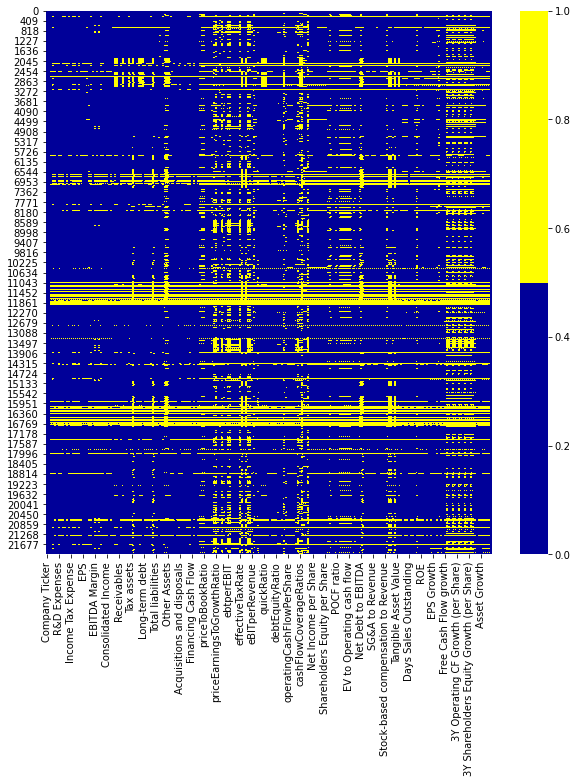

In [508]:
# missing values map BEFORE removing high-missing-value columns (yellow represents missing values)
plt.figure(figsize = (10,10))
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(fi_df[feature_cols].isnull(), cmap=sns.color_palette(colours))
plt.show()

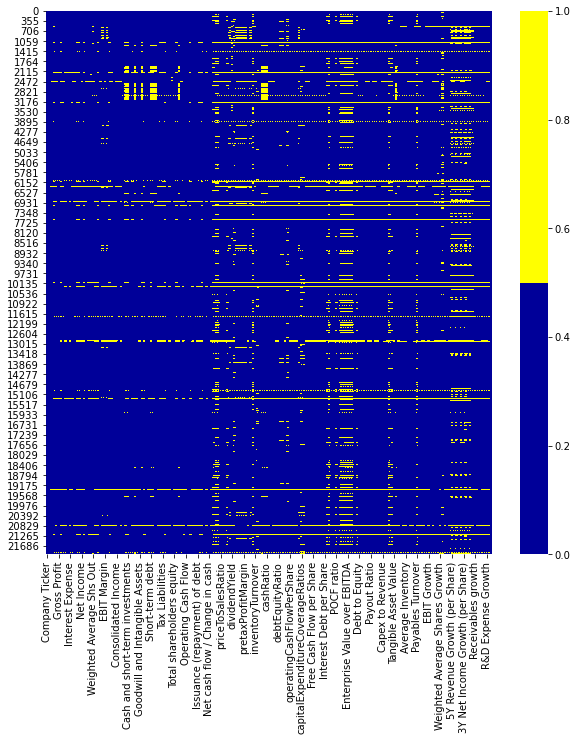

In [509]:
# missing values map AFTER removing high-missing-value columns (yellow represents missing values)
plt.figure(figsize = (10,10))
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(trimmed_fy_fi_df[trimmed_feature_cols].isnull(), cmap=sns.color_palette(colours))
plt.show()

## 3. Handling Outliers

In [510]:
trimmed_fy_fi_df.describe()

,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,2015 PRICE VAR [%],Class,2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%]
count,18630.000000,1.844300e+04,18048.000000,1.834400e+04,1.842500e+04,1.813300e+04,1.838600e+04,1.834900e+04,1.849700e+04,1.834400e+04,...,17768.000000,17901.000000,17991.000000,18017.000000,3.726000e+03,18630.000000,3726.000000,3726.000000,3726.000000,3726.000000
mean,2016.000000,5.271091e+09,3.841217,3.161091e+09,2.096463e+09,1.066460e+08,9.217452e+08,1.464213e+09,6.459718e+08,9.907217e+07,...,0.566468,2.894303,0.253207,0.212207,9.896798e+02,0.553784,108.632267,86.757578,-12.702079,21.590230
std,1.414252,2.113827e+10,328.952127,1.502364e+10,8.298855e+09,7.739922e+08,3.918700e+09,5.924354e+09,3.131871e+09,4.576225e+08,...,63.263571,144.082378,13.233591,3.588407,4.143126e+04,0.497112,3947.403495,3914.717953,80.080562,85.572902
min,2014.000000,-6.276160e+08,-6.872700,-2.986888e+09,-1.280800e+10,-1.098000e+08,-1.401594e+08,-5.495512e+09,-1.933900e+10,-1.710954e+09,...,-3963.131200,-1.051000,-2.662200,-2.099000,-1.003972e+02,0.000000,-99.947830,-99.999406,-99.992266,-99.864779
25%,2015.000000,7.462450e+07,-0.016600,4.177383e+06,3.745400e+07,0.000000e+00,1.919909e+07,3.849223e+07,-3.040000e+06,0.000000e+00,...,-0.098725,-0.066700,0.000000,-0.016400,-2.855907e+01,0.000000,-5.458562,-8.240603,-35.493104,-6.862869
50%,2016.000000,5.129800e+08,0.055850,1.656215e+08,2.255690e+08,0.000000e+00,8.724450e+07,1.671630e+08,4.366700e+07,4.228000e+06,...,0.031900,0.000000,0.000000,0.056300,-5.208147e+00,1.000000,18.104605,11.891346,-15.230046,18.474831
75%,2017.000000,2.562524e+09,0.171825,1.251886e+09,9.790000e+08,1.177300e+07,4.004442e+08,6.625920e+08,2.896080e+08,5.314850e+07,...,0.134900,0.148100,0.000000,0.169800,1.341042e+01,1.000000,41.050972,33.749872,3.096736,40.492109
max,2018.000000,8.482620e+11,42138.663900,3.861020e+11,4.621600e+11,2.883700e+10,1.856830e+11,3.056050e+11,1.565540e+11,3.152300e+10,...,7039.325900,17646.823500,1542.611000,324.926800,2.418601e+06,1.000000,212700.011623,238699.999493,3993.082711,3756.716345


There is a large difference between the maximum value and 75th percentile for some financial indicators (e.g. `Revenue Growth` and `Debt Growth`). This suggests the presence of outliers that need to be addressed. 

Since the financial performance of companies are sector-dependent, outliers will be adjusted to have the values of the 5th or 95th percentile of values for companies in the same sector. 

In [511]:
sector_vc = trimmed_fy_fi_df["Sector"].value_counts()
sector_vc

Financial Services        3240
Healthcare                2865
Technology                2790
Industrials               2470
Consumer Cyclical         2225
Basic Materials           1185
Real Estate               1115
Energy                    1065
Consumer Defensive         800
Utilities                  475
Communication Services     400
Name: Sector, dtype: int64

In [512]:
# drop the columns with non-numeric values and outcome values
feat_fy_fi_df = trimmed_fy_fi_df.drop(columns = ["Company Ticker", 
                                                 "Sector", 
                                                 "Class",
                                                 "2015 PRICE VAR [%]",
                                                 "2016 PRICE VAR [%]",
                                                 "2017 PRICE VAR [%]", 
                                                 "2018 PRICE VAR [%]", 
                                                 "2019 PRICE VAR [%]"
                                                 ])

In [513]:
sector_df_lst = []
for sector in sector_vc.index:
    sector_df = feat_fy_fi_df[trimmed_fy_fi_df["Sector"] == sector]
    upper_qt = sector_df.quantile(0.95)
    lower_qt = sector_df.quantile(0.05)
    
    # setting upper outliers to 95th percentile value
    sector_df = sector_df.mask(feat_fy_fi_df > upper_qt, upper_qt, axis = 1) 
    # setting lower outliers to 5th percentile value
    sector_df = sector_df.mask(feat_fy_fi_df < lower_qt, lower_qt, axis = 1)
    sector_df_lst.append(sector_df)

ol_proc_fy_fi_df = pd.concat(sector_df_lst)

In [514]:
ol_proc_fy_fi_df.describe()

,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,3Y Shareholders Equity Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth
count,18630.000000,1.844300e+04,18048.000000,1.834400e+04,1.842500e+04,1.813300e+04,1.838600e+04,1.834900e+04,1.849700e+04,1.834400e+04,...,16712.000000,15869.000000,17310.000000,17990.000000,17985.000000,18019.000000,17768.000000,17901.000000,17991.000000,18017.000000
mean,2016.000000,3.357710e+09,0.123683,1.782445e+09,1.376074e+09,4.109197e+07,5.653437e+08,9.445167e+08,4.033702e+08,7.153422e+07,...,0.027057,0.007797,0.013612,0.114741,0.037455,0.131455,0.052074,0.110401,0.055326,0.105655
std,1.414252,7.947861e+09,0.416012,4.664015e+09,3.943797e+09,1.534209e+08,1.490606e+09,2.796667e+09,1.058507e+09,2.244206e+08,...,0.161293,0.151978,0.155458,0.448655,0.182147,0.397886,0.402402,0.474646,0.234551,0.234615
min,2014.000000,0.000000e+00,-0.717790,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.036458e+06,-1.251300e+09,0.000000e+00,...,-0.528120,-1.000000,-1.000000,-0.860700,-0.429000,-0.451280,-0.967220,-1.000000,-0.609550,-0.311700
25%,2015.000000,7.462450e+07,-0.016600,5.316995e+06,3.745400e+07,0.000000e+00,1.919909e+07,3.849223e+07,-3.040000e+06,0.000000e+00,...,-0.032300,0.000000,0.000000,-0.050700,0.000000,-0.032650,-0.098725,-0.066700,0.000000,-0.016400
50%,2016.000000,5.129800e+08,0.055850,1.656215e+08,2.255690e+08,0.000000e+00,8.724450e+07,1.671630e+08,4.366700e+07,4.228000e+06,...,0.027400,0.000000,0.000000,0.009550,0.000000,0.044900,0.031900,0.000000,0.000000,0.056300
75%,2017.000000,2.562524e+09,0.171825,1.228678e+09,9.790000e+08,1.071800e+07,3.939750e+08,6.625920e+08,2.896080e+08,5.314850e+07,...,0.100125,0.036300,0.045500,0.191700,0.052500,0.161700,0.134900,0.148100,0.000000,0.169800
max,2018.000000,1.041537e+11,3.464160,4.204978e+10,7.266995e+10,1.233500e+09,2.229990e+10,4.737248e+10,1.357473e+10,4.099304e+09,...,0.524040,0.397500,0.518300,3.132200,0.799360,3.001120,2.293280,1.983840,1.543920,1.370000


Based on the summary statistics above, the difference between the maximum values and the 75th percentile values has been much reduced.

In [515]:
# sorting the index so that the outcome columns can be re-added
ol_proc_fy_fi_df = ol_proc_fy_fi_df.sort_index()

In [516]:
# adding the outcome columns back to the dataset
ol_proc_fy_fi_df.insert(0, "Company Ticker", trimmed_fy_fi_df["Company Ticker"])
ol_proc_fy_fi_df = ol_proc_fy_fi_df.join(trimmed_fy_fi_df[["Sector", 
                                         "Class",
                                         "2015 PRICE VAR [%]",
                                         "2016 PRICE VAR [%]",
                                         "2017 PRICE VAR [%]", 
                                         "2018 PRICE VAR [%]", 
                                         "2019 PRICE VAR [%]"]])

In [517]:
ol_proc_fy_fi_df.head()

,Company Ticker,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,Class,2015 PRICE VAR [%],2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%]
0,PG,2014,6.236865e+10,-0.07130,3.903000e+10,2.135020e+10,0.0,8.848118e+09,1.086848e+10,8.659150e+09,...,0.1228,0.000000,-0.153370,Consumer Defensive,0,-9.323276,NaN,NaN,NaN,NaN
1,VIPS,2014,3.734148e+09,0.47266,2.805625e+09,9.285226e+08,9562700.0,3.441414e+08,7.939267e+08,1.345959e+08,...,NaN,0.004385,0.465515,Consumer Defensive,0,-25.512193,NaN,NaN,NaN,NaN
2,KR,2014,6.236865e+10,0.01820,4.101700e+10,2.023700e+10,0.0,8.848118e+09,1.086848e+10,2.725000e+09,...,0.2738,0.000000,0.023400,Consumer Defensive,1,33.118297,NaN,NaN,NaN,NaN
3,RAD,2014,2.552641e+10,0.00530,1.820268e+10,7.323734e+09,0.0,6.561162e+09,6.586482e+09,7.372520e+08,...,-0.0458,0.000000,-0.006000,Consumer Defensive,1,2.752291,NaN,NaN,NaN,NaN
4,GIS,2014,1.790960e+10,0.00760,1.153980e+10,6.369800e+09,0.0,3.474300e+09,3.412400e+09,2.957400e+09,...,0.1025,0.000000,-0.022000,Consumer Defensive,1,12.897715,NaN,NaN,NaN,NaN


## 4. Filling Missing Values

Before filling missing values, the year-based `PRICE VAR [%]` variables (e.g. `2015 PRICE VAR [%]`) must be combined into a single column. That would ensure that the output columns do not have any missing values. 

In [518]:
ol_proc_fy_fi_df["PRICE VAR [%]"] = ol_proc_fy_fi_df.iloc[:, -5:].sum(axis = 1)
ol_proc_fy_fi_df = ol_proc_fy_fi_df.drop(columns = ol_proc_fy_fi_df.columns[-6:-1])

In [519]:
missing_data_vc = ol_proc_fy_fi_df.count()
num_entries  = len(ol_proc_fy_fi_df.index)
missing_data_vc_dct = {feat: num_entries - v for feat, v in zip(missing_data_vc.index, missing_data_vc)}
missing_data_vc_dct

{'Company Ticker': 0,
 'Year': 0,
 'Revenue': 187,
 'Revenue Growth': 582,
 'Cost of Revenue': 286,
 'Gross Profit': 205,
 'R&D Expenses': 497,
 'SG&A Expense': 244,
 'Operating Expenses': 281,
 'Operating Income': 133,
 'Interest Expense': 286,
 'Earnings before Tax': 276,
 'Income Tax Expense': 194,
 'Net Income - Non-Controlling int': 540,
 'Net Income - Discontinued ops': 540,
 'Net Income': 204,
 'Preferred Dividends': 540,
 'Net Income Com': 73,
 'EPS': 258,
 'EPS Diluted': 249,
 'Weighted Average Shs Out': 419,
 'Weighted Average Shs Out (Dil)': 413,
 'Dividend per Share': 540,
 'Gross Margin': 197,
 'EBITDA Margin': 799,
 'EBIT Margin': 260,
 'Profit Margin': 797,
 'Free Cash Flow margin': 553,
 'EBITDA': 306,
 'EBIT': 144,
 'Consolidated Income': 204,
 'Earnings Before Tax Margin': 197,
 'Net Profit Margin': 274,
 'Cash and cash equivalents': 152,
 'Short-term investments': 1286,
 'Cash and short-term investments': 1243,
 'Receivables': 159,
 'Inventories': 329,
 'Total curren

As financial performance is very sector-dependent, we will fill missing values with the median value of a feature among companies in a certain sector. 

In [520]:
cleaned_df = ol_proc_fy_fi_df.groupby(["Sector"]).transform(lambda x: x.fillna(x.median(axis = 0)))
cleaned_df.insert(0, "Company Ticker", ol_proc_fy_fi_df["Company Ticker"])
cleaned_df.insert(len(ol_proc_fy_fi_df.columns) - 3, "Sector", ol_proc_fy_fi_df["Sector"])

## 5. View and Export Cleaned Data

In [521]:
cleaned_df.describe()

,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Class,PRICE VAR [%]
count,18630.000000,1.863000e+04,18630.000000,1.863000e+04,1.863000e+04,1.863000e+04,1.863000e+04,1.863000e+04,1.863000e+04,1.863000e+04,...,18630.000000,18630.000000,18630.000000,18630.000000,18630.000000,18630.000000,18630.000000,18630.000000,18630.000000,1.863000e+04
mean,2016.000000,3.328800e+09,0.121565,1.757352e+09,1.364513e+09,4.002935e+07,5.593383e+08,9.339851e+08,4.010642e+08,7.075809e+07,...,0.012832,0.111507,0.036276,0.128530,0.050853,0.106340,0.053696,0.103877,0.553784,2.387916e+02
std,1.414252,7.913390e+09,0.409648,4.632542e+09,3.923893e+09,1.514990e+08,1.481748e+09,2.777098e+09,1.055095e+09,2.228024e+08,...,0.149882,0.441236,0.179079,0.391646,0.393059,0.465711,0.230693,0.230980,0.497112,1.869657e+04
min,2014.000000,0.000000e+00,-0.717790,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.036458e+06,-1.251300e+09,0.000000e+00,...,-1.000000,-0.860700,-0.429000,-0.451280,-0.967220,-1.000000,-0.609550,-0.311700,0.000000,-1.003972e+02
25%,2015.000000,7.604650e+07,-0.012700,4.310124e+06,3.836356e+07,0.000000e+00,1.951125e+07,3.947925e+07,-2.828250e+06,0.000000e+00,...,0.000000,-0.044475,0.000000,-0.029500,-0.088450,-0.059400,0.000000,-0.012900,0.000000,-2.023281e+01
50%,2016.000000,5.001530e+08,0.055650,1.598150e+08,2.215005e+08,0.000000e+00,8.906200e+07,1.640900e+08,4.425206e+07,4.281000e+06,...,0.000000,0.010600,0.000000,0.045250,0.032500,0.000000,0.000000,0.056800,1.000000,4.457173e+00
75%,2017.000000,2.512072e+09,0.165900,1.186672e+09,9.638195e+08,9.771802e+06,3.850000e+08,6.509048e+08,2.863988e+08,5.210000e+07,...,0.032300,0.181200,0.045475,0.155500,0.127000,0.134250,0.000000,0.163000,1.000000,2.920559e+01
max,2018.000000,1.041537e+11,3.464160,4.204978e+10,7.266995e+10,1.233500e+09,2.229990e+10,4.737248e+10,1.357473e+10,4.099304e+09,...,0.518300,3.132200,0.799360,3.001120,2.293280,1.983840,1.543920,1.370000,1.000000,2.418601e+06


In [522]:
cleaned_df.shape

(18630, 195)

In [523]:
df_class = cleaned_df["Class"].value_counts()
print(df_class)

1    10317
0     8313
Name: Class, dtype: int64


The `class` column is slightly imbalanced, with slightly more price increases (1) than price decreases (0). 

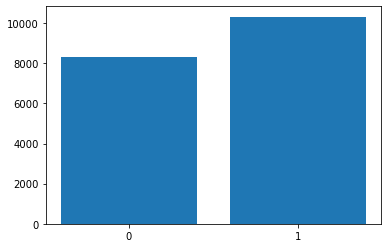

In [524]:
# Plot class distribution
df_class = cleaned_df['Class'].value_counts()
plt.bar(df_class.keys(), df_class)
plt.xticks(df_class.keys())
plt.show()

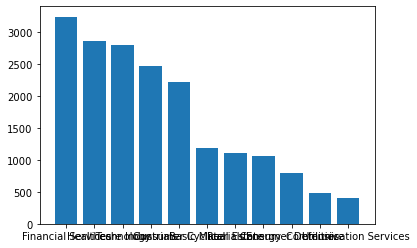

In [525]:
# Plot class distribution
df_class = cleaned_df['Sector'].value_counts()
plt.bar(df_class.keys(), df_class)
plt.xticks(df_class.keys())
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

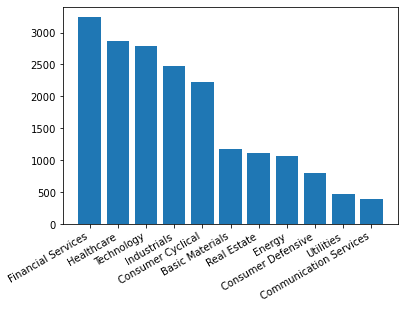

In [526]:
# Plot class distribution
df_class = cleaned_df['Sector'].value_counts()
ax = plt.gca()
plt.bar(df_class.keys(), df_class)
plt.xticks(df_class.keys())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [527]:
cleaned_df[cleaned_df.isna().any(axis = 1)]

,Company Ticker,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,Class,PRICE VAR [%]


In [528]:
cleaned_df["Company Ticker"].value_counts()

VEON    5
BBY     5
EQS     5
ATVI    5
KW      5
       ..
TTOO    5
NGHC    5
CMG     5
ENSG    5
SAIC    5
Name: Company Ticker, Length: 3726, dtype: int64

In [529]:
cleaned_df["Year"].value_counts()

2015    3726
2014    3726
2018    3726
2017    3726
2016    3726
Name: Year, dtype: int64

There are 3726 companies, and 3726 rows per year. 

In [530]:
cleaned_df.head()

,Company Ticker,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,Class,PRICE VAR [%]
0,PG,2014,6.236865e+10,-0.07130,3.903000e+10,2.135020e+10,0.0,8.848118e+09,1.086848e+10,8.659150e+09,...,-0.01870,-0.02170,0.0359,0.0316,0.1228,0.000000,-0.153370,Consumer Defensive,0,-9.323276
1,VIPS,2014,3.734148e+09,0.47266,2.805625e+09,9.285226e+08,9562700.0,3.441414e+08,7.939267e+08,1.345959e+08,...,0.02475,0.01405,0.0358,0.0396,0.0000,0.004385,0.465515,Consumer Defensive,0,-25.512193
2,KR,2014,6.236865e+10,0.01820,4.101700e+10,2.023700e+10,0.0,8.848118e+09,1.086848e+10,2.725000e+09,...,0.06180,0.09810,0.1886,0.3268,0.2738,0.000000,0.023400,Consumer Defensive,1,33.118297
3,RAD,2014,2.552641e+10,0.00530,1.820268e+10,7.323734e+09,0.0,6.561162e+09,6.586482e+09,7.372520e+08,...,0.02110,-0.05100,-0.0189,0.1963,-0.0458,0.000000,-0.006000,Consumer Defensive,1,2.752291
4,GIS,2014,1.790960e+10,0.00760,1.153980e+10,6.369800e+09,0.0,3.474300e+09,3.412400e+09,2.957400e+09,...,0.02570,0.00900,0.0215,0.0274,0.1025,0.000000,-0.022000,Consumer Defensive,1,12.897715


In [531]:
cleaned_df.to_csv("datasets/cleaned_df.csv")

EDA

In [532]:
cleaned_data = pd.read_csv("datasets/cleaned_df.csv")

cleaned_data = cleaned_data.drop(columns = "Unnamed: 0")

numeric_data = cleaned_data.drop(columns = ["Company Ticker", 
                                                 "Sector", 
                                                 "Class",
                                                 "PRICE VAR [%]"
                                                 ])

In [533]:
Y_1 = cleaned_data['Class']
Y_2 = cleaned_data["PRICE VAR [%]"]

In [534]:
cat_1 = cleaned_data['Company Ticker']
cat_2 = cleaned_data['Sector']

In [535]:
pd.get_dummies(cat_1, prefix='Company')

,Company_A,Company_AA,Company_AABA,Company_AAL,Company_AAMC,Company_AAME,Company_AAN,Company_AAOI,Company_AAON,Company_AAPL,...,Company_ZION,Company_ZIOP,Company_ZIXI,Company_ZN,Company_ZNGA,Company_ZNH,Company_ZSAN,Company_ZTS,Company_ZUMZ,Company_ZYNE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18626,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [536]:
cat_data = pd.get_dummies(cat_2, prefix='sector')

## Numeric Data

In [537]:
check_corr = pd.concat([numeric_data,Y_1],axis = 1)

In [538]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = check_corr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

KeyboardInterrupt: 

## set correlation threshold to 0.08 and 23 features left

In [329]:
cor_target.describe()

count    191.000000
mean       0.052952
std        0.075084
min        0.000810
25%        0.024898
50%        0.046055
75%        0.067282
max        1.000000
Name: Class, dtype: float64

In [539]:
#Correlation with output variable
cor_target = abs(cor["Class"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.01]
len(relevant_features)

169

In [540]:
rele_columns = relevant_features.index[:-1]


In [541]:
rele_columns

Index(['Year', 'Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       '5Y Shareholders Equity Growth (per Share)',
       '3Y Shareholders Equity Growth (per Share)',
       '5Y Dividend per Share Growth (per Share)',
       '3Y Dividend per Share Growth (per Share)', 'Receivables growth',
       'Inventory Growth', 'Asset Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth'],
      dtype='object', length=168)

In [542]:
corr_2 = numeric_data[rele_columns]

In [543]:
plt.figure(figsize=(12,10))
cor = corr_2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000242CBD4CF70> (for post_execute):


KeyboardInterrupt: 

## we can see that EPS and EPS Diluted; cashRatio and quickRatio; POCF ratio and priceToOperatingCashFlowsRatio; EV to Operating cash flow and priceToOperatingCashFlowsRatio; ROE and returnOnEquity; Graham Net-Net and companyEquityMultiplier; Enterprise Value and Market Cap; EV to Operating cash flow and POCF ratio; Weighted Average Shares Diluted Growth and Weighted Average Shares Growth are highly correlated

Thus, we drop one of each pair: EPS Diluted, quickRatio, POCF ratio, priceToOperatingCashFlowsRatio,returnOnEquity,Enterprise Value, companyEquityMultiplier, Weighted Average Shares Diluted Growth.

In [544]:
rest_features = ['EPS', 'Dividend per Share', 
       'cashRatio', 'Market Cap',
      'Enterprise Value over EBITDA',
       'EV to Operating cash flow', 'Earnings Yield', 'Free Cash Flow Yield',
       'Graham Number', 'Graham Net-Net', 'ROE',
       'Weighted Average Shares Growth',
       '5Y Revenue Growth (per Share)', '3Y Revenue Growth (per Share)', 'Year']

In [545]:
selected_features = numeric_data[rest_features]

In [546]:
final_features = pd.concat([selected_features,cat_data],axis = 1)

In [547]:
df = pd.concat([final_features,Y_1],axis = 1)

In [548]:
#df = df.sample(frac = 1) # we shuffle the data so that our train/test split will be truly random

#train_proportion = 0.8
#n = len(df)
#print('Size of dataset: ', str(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
#t = int(train_proportion * n)

target = df[['Class','Year']]
price_columns = ['Class']
data = df.loc[:, ~df.columns.isin(price_columns)]

# the following variable records the features of examples in the training set
train_x_df = data.loc[data['Year'] != 2018]
train_x = train_x_df.loc[:, ~train_x_df.columns.isin(['Year'])]
# the following variable records the features of examples in the test set
test_x_df = data.loc[data['Year'] == 2018]
test_x = test_x_df.loc[:, ~test_x_df.columns.isin(['Year'])]
# the following variable records the labels of examples in the training set
train_y_df = target.loc[data['Year'] != 2018]
train_y = train_y_df.loc[:, ~train_y_df.columns.isin(['Year'])]
# the following variable records the labels of examples in the test set
test_y_df = target.loc[data['Year'] == 2018]
test_y = test_y_df.loc[:, ~test_y_df.columns.isin(['Year'])]

In [549]:
train_x_np = np.asarray(train_x)
test_x_np = np.asarray(test_x)
train_y_np = np.asarray(train_y)
test_y_np = np.asarray(test_y)

## normalization


In [550]:
def normalize(x,s=None,m=None):
  if s is None or m is None:
    s = np.std(x,axis=0)
    m = np.mean(x,axis=0)
  x = (x-m)/s
  return x,s,m

In [551]:
x,s,m = normalize(train_x_np[:,:-11])
x_test,_,_ = normalize(test_x_np[:,:-11],s,m)

In [ ]:
train_x_np = np.concatenate((x,train_x_np[:,-11:]),axis = 1)
test_x_np = np.concatenate((x_test,test_x_np[:,-11:]),axis = 1)

In [ ]:
clf = LogisticRegression(random_state=0).fit(train_x_np, train_y_np)

In [ ]:
clf.score(test_x_np, test_y_np)

In [ ]:
y_pred = clf.predict(test_x_np)

In [ ]:
f1_score(test_y_np, y_pred, average='weighted')

In [ ]:
clf_dt = DecisionTreeClassifier().fit(train_x_np, train_y_np)

clf_dt.score(test_x_np, test_y_np)

In [ ]:
y_pred = clf_dt.predict(test_x_np)

f1_score(test_y_np, y_pred, average='weighted')

In [ ]:
clf_rf = RandomForestClassifier().fit(train_x_np, train_y_np)

clf_rf.score(test_x_np, test_y_np)

In [ ]:
y_pred = clf_rf.predict(test_x_np)

print(f1_score(test_y_np, y_pred, average='weighted'))

Split according to class distribution

In [ ]:
# Ratio of class distribution
class_dist_1 = df_class[1]/(df_class[0]+df_class[1])
class_dist_0 = df_class[0]/(df_class[0]+df_class[1])

In [ ]:
print("Ratio of class values = 1:",class_dist_1)
print("Ratio of class values = 0:",class_dist_0)

In [ ]:
train, test = train_test_split(df, test_size=0.2, stratify=df['Class'])

# the following variable records the features of examples in the training set
train_x = train.loc[:, ~train.columns.isin(['Class', 'Year'])]
# the following variable records the features of examples in the test set
test_x = test.loc[:, ~test.columns.isin(['Class', 'Year'])]
# the following variable records the labels of examples in the training set
train_y = train['Class']
# the following variable records the labels of examples in the test set
test_y = test['Class']

In [ ]:
train_x_np = np.asarray(train_x)
test_x_np = np.asarray(test_x)
train_y_np = np.asarray(train_y)
test_y_np = np.asarray(test_y)

In [ ]:
x,s,m = normalize(train_x_np[:,:-11])
x_test,_,_ = normalize(test_x_np[:,:-11],s,m)

In [ ]:
train_x_np = np.concatenate((x,train_x_np[:,-11:]),axis = 1)
test_x_np = np.concatenate((x_test,test_x_np[:,-11:]),axis = 1)

Logistic Regression

In [ ]:
clf = LogisticRegression(random_state=0).fit(train_x_np, train_y_np)

clf.score(test_x_np, test_y_np)

In [ ]:
y_pred = clf.predict(test_x_np)

f1_score(test_y_np, y_pred, average='weighted')

Decision Trees

In [ ]:
clf_dt = DecisionTreeClassifier().fit(train_x_np, train_y_np)

clf_dt.score(test_x_np, test_y_np)

In [ ]:
y_pred = clf_dt.predict(test_x_np)

f1_score(test_y_np, y_pred, average='weighted')

Random Forest

In [ ]:
clf_rf = RandomForestClassifier().fit(train_x_np, train_y_np)

clf_rf.score(test_x_np, test_y_np)

In [ ]:
y_pred = clf_rf.predict(test_x_np)

print(f1_score(test_y_np, y_pred, average='weighted'))

Regression

In [ ]:
check_corr = pd.concat([numeric_data,Y_2],axis = 1)

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = check_corr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(cor["PRICE VAR [%]"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.001]
relevant_features

In [ ]:
abs(cor["PRICE VAR [%]"]).describe()

In [ ]:
rele_columns = relevant_features.index[:-1]
rele_columns

In [ ]:
corr_2 = numeric_data[rele_columns]

In [ ]:
plt.figure(figsize=(19,19))
cor = corr_2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
rest_features = ['Year', 'Revenue Growth', 'EPS', 'EPS Diluted', 'Dividend per Share',
       'Gross Margin', 'Issuance (buybacks) of shares', 'Financing Cash Flow',
       'Free Cash Flow', 'Net Cash/Marketcap', 'priceBookValueRatio',
       'priceToBookRatio', 'priceEarningsRatio', 'priceToFreeCashFlowsRatio',
       'priceFairValue', 'grossProfitMargin', 'assetTurnover',
       'daysOfSalesOutstanding', 'longtermDebtToCapitalization',
       'totalDebtToCapitalization', 'interestCoverage', 'freeCashFlowPerShare',
       'Free Cash Flow per Share', 'Book Value per Share', 'PE ratio',
       'PFCF ratio', 'PB ratio', 'PTB ratio', 'EV to Free cash flow',
       'Earnings Yield', 'Free Cash Flow Yield', 'Interest Coverage',
       'Dividend Yield', 'Capex to Revenue', 'Capex to Depreciation',
       'Graham Number', 'Days of Inventory on Hand', 'Receivables Turnover',
       'Gross Profit Growth', 'EBIT Growth', 'Operating Income Growth',
       'Net Income Growth', 'Weighted Average Shares Growth',
       'Weighted Average Shares Diluted Growth', 'Operating Cash Flow growth',
       'Free Cash Flow growth', 'Asset Growth', 'Debt Growth',
       'SG&A Expenses Growth']

In [ ]:
selected_features = numeric_data[rest_features]

In [ ]:
final_features = pd.concat([selected_features,cat_data],axis = 1)

In [ ]:
df_regression = pd.concat([final_features,Y_2],axis = 1)
df_regression.keys()

In [ ]:
#df_regression_original = df_regression
#df_regression = df_regression.drop([3243, 7291])

In [ ]:
train, test = train_test_split(df_regression, random_state=43, test_size=0.2)

# the following variable records the features of examples in the training set
train_x = train.loc[:, ~train.columns.isin(['PRICE VAR [%]', 'Year'])]
# the following variable records the features of examples in the test set
test_x = test.loc[:, ~test.columns.isin(['PRICE VAR [%]', 'Year'])]
# the following variable records the labels of examples in the training set
train_y = train['PRICE VAR [%]']
# the following variable records the labels of examples in the test set
test_y = test['PRICE VAR [%]']

In [ ]:
train_x_np = np.asarray(train_x)
test_x_np = np.asarray(test_x)
train_y_np = np.asarray(train_y)
test_y_np = np.asarray(test_y)

In [ ]:
train_vals = np.concatenate((train_x_np, np.reshape(np.ones(len(train_x_np)), (len(train_x_np),1))), axis=1)

test_vals = np.concatenate((test_x_np, np.reshape(np.ones(len(test_x_np)), (len(test_x_np),1))), axis=1)


In [ ]:
# This function just computes the mean squared error
def MSE(y, pred):
    summ = 0
    y = np.asarray(y)
    for i in range(len(y)):
        summ += (y[i] - pred[i])**2
        
    return summ/len(y)

# This function plots the main diagonal;for a "predicted vs true" plot with perfect predictions, all data lies on this line
def plotDiagonal(xmin, xmax):
    xsamples = np.arange(xmin,xmax,step=0.01)
    plt.plot(xsamples,xsamples,c='black')

# This helper function plots x vs y and labels the axes
def plotdata(x=None,y=None,xname=None,yname=None,margin=0.05,plotDiag=True,zeromin=False):
    plt.scatter(x,y,label='data')
    plt.xlabel(xname)
    plt.ylabel(yname)
    range_x = max(x) - min(x)
    range_y = max(y) - min(y)
    if plotDiag:
        plotDiagonal(min(x)-margin*range_x,max(x)+margin*range_x)
    if zeromin:
        plt.xlim(0.0,max(x)+margin*range_x)
        plt.ylim(0.0,max(y)+margin*range_y)
    else:
        plt.xlim(min(x)-margin*range_x,max(x)+margin*range_x)
        plt.ylim(min(y)-margin*range_y,max(y)+margin*range_y)
    plt.show()

# This function plots the predicted labels vs the actual labels (We only plot the first 1000 points to avoid slow plots)
def plot_pred_true(test_pred=None, test_y=None, max_points = 1000):
    plotdata(test_pred[1:max_points], test_y[1:max_points],'Predicted', 'True', zeromin=True)

In [ ]:
# This function runs OLS and bypasses any SVD (Singular Value Decomposition) convergence errors by refitting the model
def run_OLS(train_y, test_y, train_vals, test_vals):
    ols_model = sm.regression.linear_model.OLS(train_y, train_vals)
    while True: # Bypasses SVD convergence assertion error
        try:
            results = ols_model.fit()
            break
        except:
            None
            
    w = np.array(results.params).reshape([len(results.params),1])

    train_pred = np.matmul(train_vals,w)
    test_pred = np.matmul(test_vals,w)

    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())
    
    return train_MSE, test_MSE, test_pred

In [ ]:
train_MSE, test_MSE, test_pred = run_OLS(train_y_np, test_y_np, train_vals, test_vals)

In [ ]:
print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y_np) #.flatten() will make sure the dimensions match

In [ ]:
test_pred

In [ ]:
max(test_y_np)

In [ ]:
target_dict={}

for index, value in test_y.items():
    
    if value == max(test_y):
        print(index)


In [ ]:
gg = test_y.sort_values(ascending=False)

In [ ]:
gg.head(20)

In [ ]:
min(test_y)

In [ ]:
reg = LinearRegression().fit(train_x_np, train_y_np)
reg.score(test_x_np, test_y_np)

In [ ]:
train_x.keys()

In [ ]:
test_y

In [ ]:
df_regression

class distribution split

In [ ]:
lr_score = []
lr_f1 = []
dt_score = []
dt_f1 = []
rf_score = []
rf_f1 = []


for i in range(1000):
    train, test = train_test_split(df, test_size=0.2, stratify=df['Class'])

    # the following variable records the features of examples in the training set
    train_x = train.loc[:, ~train.columns.isin(['Class', 'Year'])]
    # the following variable records the features of examples in the test set
    test_x = test.loc[:, ~test.columns.isin(['Class', 'Year'])]
    # the following variable records the labels of examples in the training set
    train_y = train['Class']
    # the following variable records the labels of examples in the test set
    test_y = test['Class']
    
    train_x_np = np.asarray(train_x)
    test_x_np = np.asarray(test_x)
    train_y_np = np.asarray(train_y)
    test_y_np = np.asarray(test_y)
    
    x,s,m = normalize(train_x_np[:,:-11])
    x_test,_,_ = normalize(test_x_np[:,:-11],s,m)
    
    train_x_np = np.concatenate((x,train_x_np[:,-11:]),axis = 1)
    test_x_np = np.concatenate((x_test,test_x_np[:,-11:]),axis = 1)
    
    ## Logistic Regression
    clf = LogisticRegression(random_state=0).fit(train_x_np, train_y_np)
    
    lr_score.append(clf.score(test_x_np, test_y_np))
    
    y_pred = clf.predict(test_x_np)
    
    lr_f1.append(f1_score(test_y_np, y_pred, average='weighted'))
    
    ## Decision Tree
    clf_dt = DecisionTreeClassifier().fit(train_x_np, train_y_np)

    dt_score.append(clf_dt.score(test_x_np, test_y_np))

    y_pred = clf_dt.predict(test_x_np)

    dt_f1.append(f1_score(test_y_np, y_pred, average='weighted'))

    clf_rf = RandomForestClassifier().fit(train_x_np, train_y_np)

    rf_score.append(clf_rf.score(test_x_np, test_y_np))

    y_pred = clf_rf.predict(test_x_np)

    rf_f1.append(f1_score(test_y_np, y_pred, average='weighted'))

In [ ]:
avg_lr_score = sum(lr_score)/1000
avg_lr_f1 = sum(lr_f1)/1000
avg_dt_score = sum(dt_score)/1000
avg_dt_f1 = sum(dt_f1)/1000
avg_rf_score = sum(rf_score)/1000
avg_rf_f1 = sum(rf_f1)/1000

In [ ]:
print("Avg LR Score", avg_lr_score)
print("Avg LR F1 score", avg_lr_f1)
print("Avg DT Score", avg_dt_score)
print("Avg DT F1 score", avg_dt_f1)
print("Avg RF Score", avg_rf_score)
print("Avg RF F1 score", avg_rf_f1)

In [ ]:
scores_df = pd.read_csv("classification_scores.csv")

In [ ]:
scores_df.index=['Random Sampling', 'Stratified Sampling', 'Temporal Sampling']

In [ ]:
scores_df

In [ ]:
f1_df = pd.read_csv("f1_scores.csv")

f1_df.index=['Random Sampling', 'Stratified Sampling', 'Temporal Sampling']

f1_df

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

examples = pd.DataFrame(np.random.rand(10,4), columns=['a', 'b', 'c', 'labels'])
g = sns.PairGrid(examples, x_vars=['a', 'b', 'c'], y_vars='labels')    
g = g.map(plt.plot)

## Sector Analysis

### Uncleaned Data

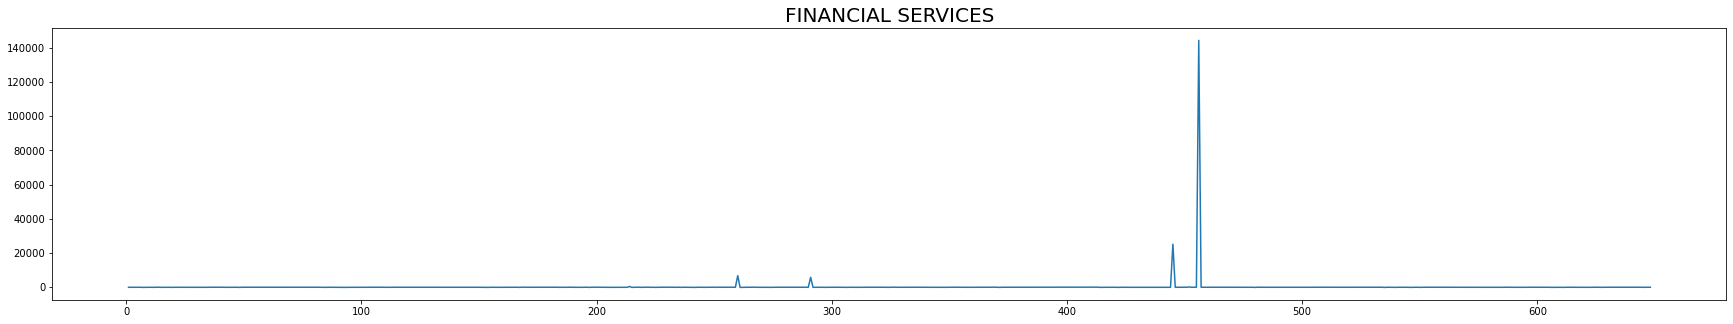

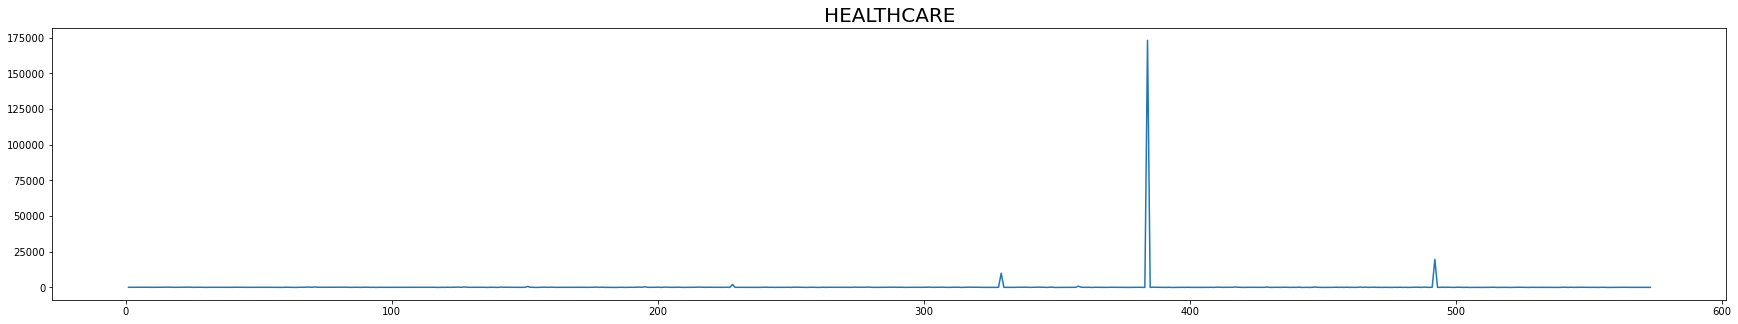

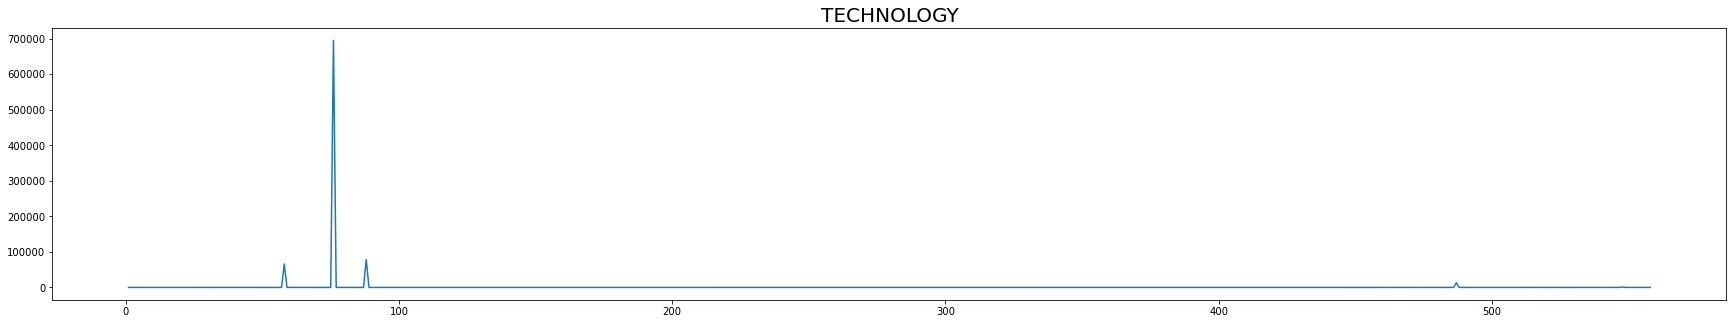

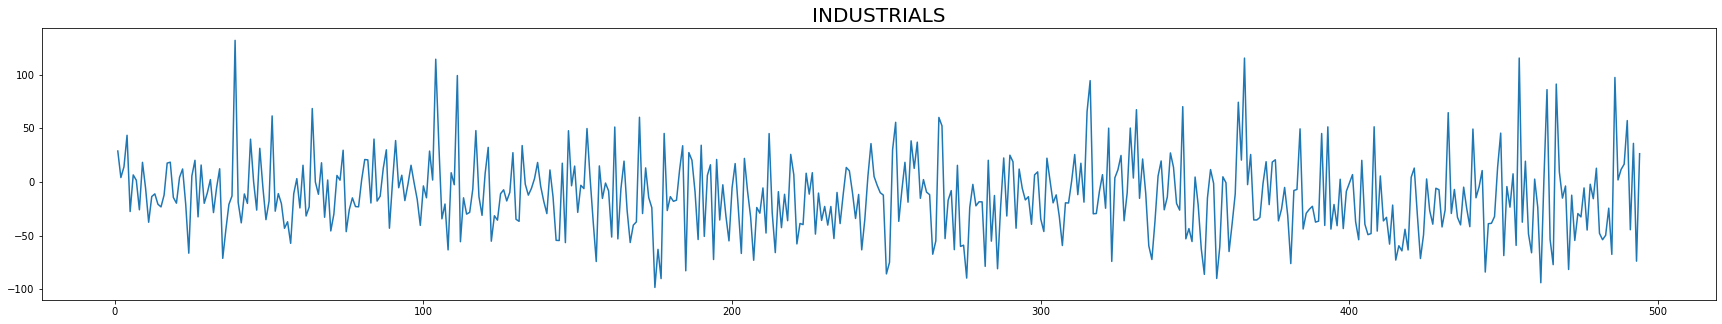

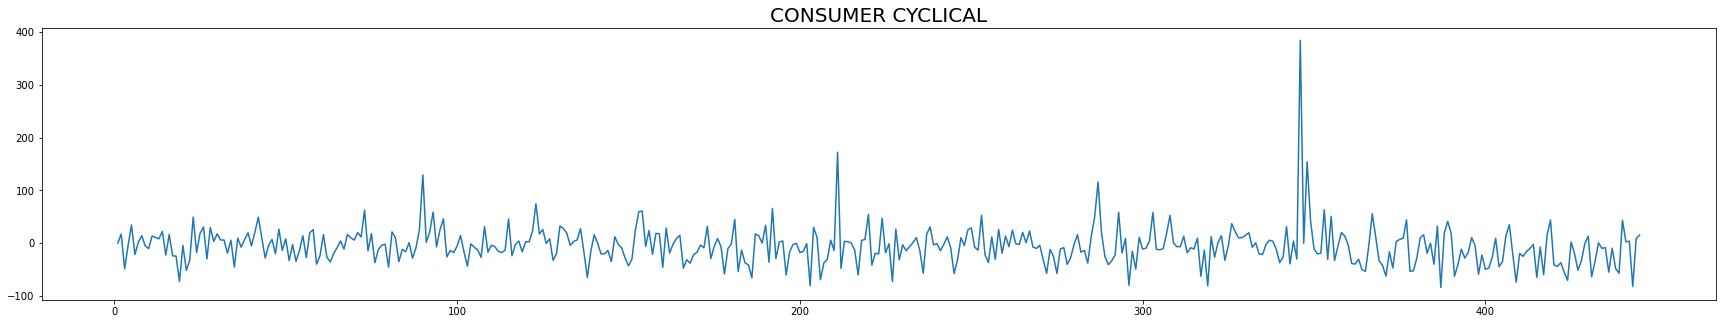

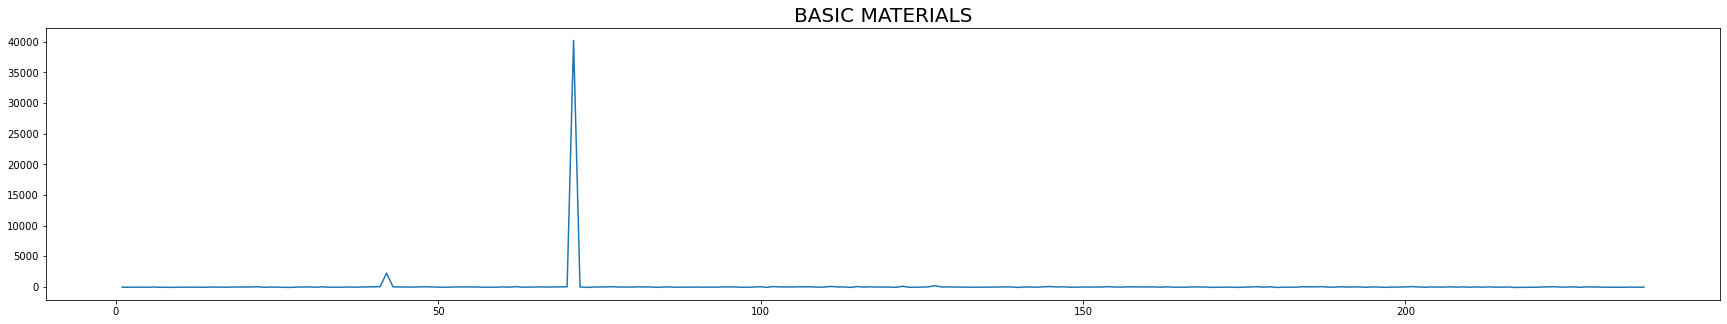

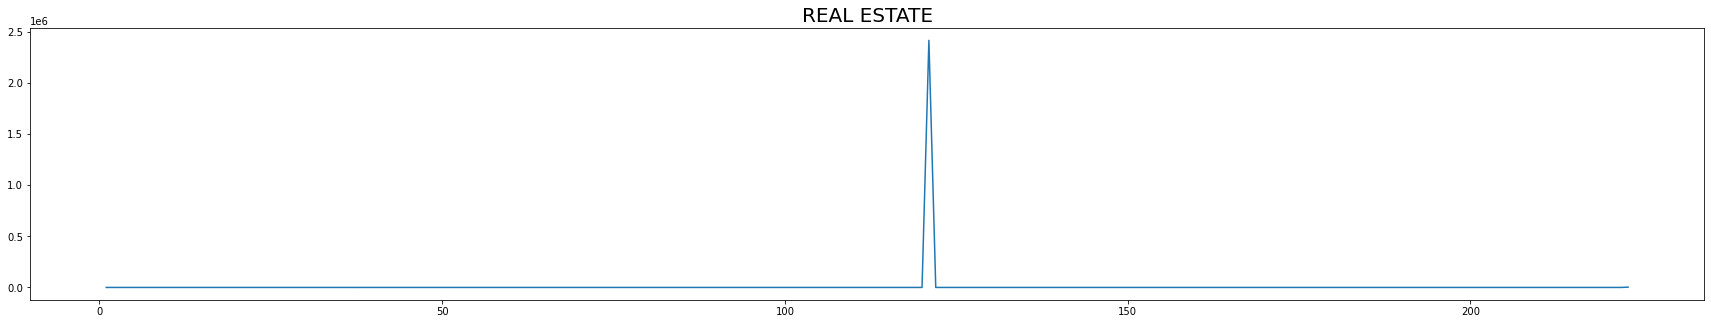

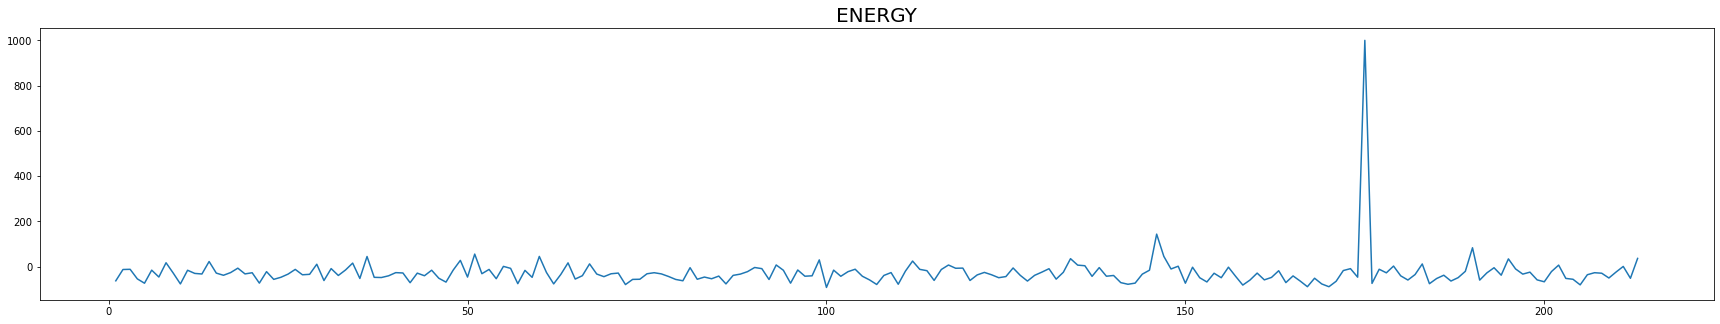

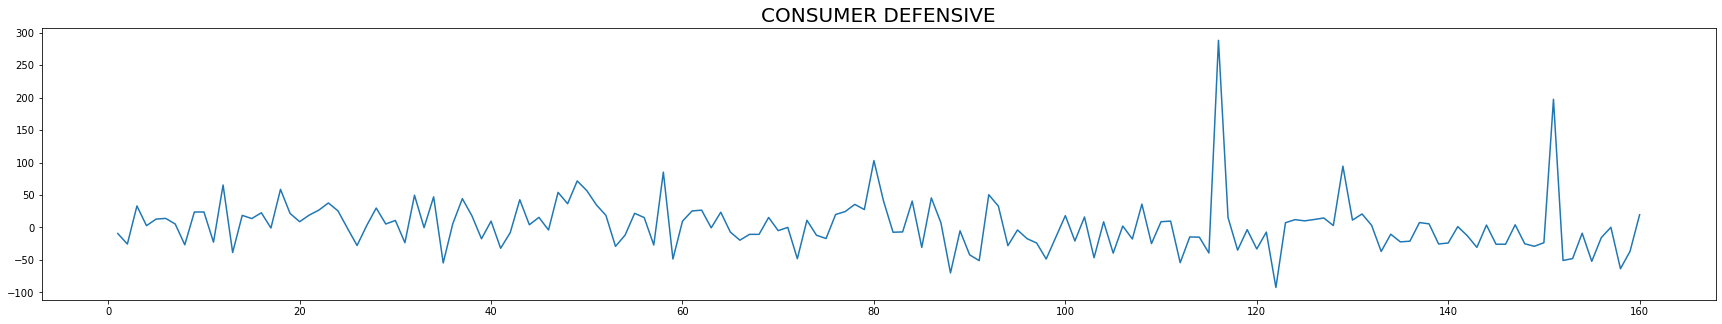

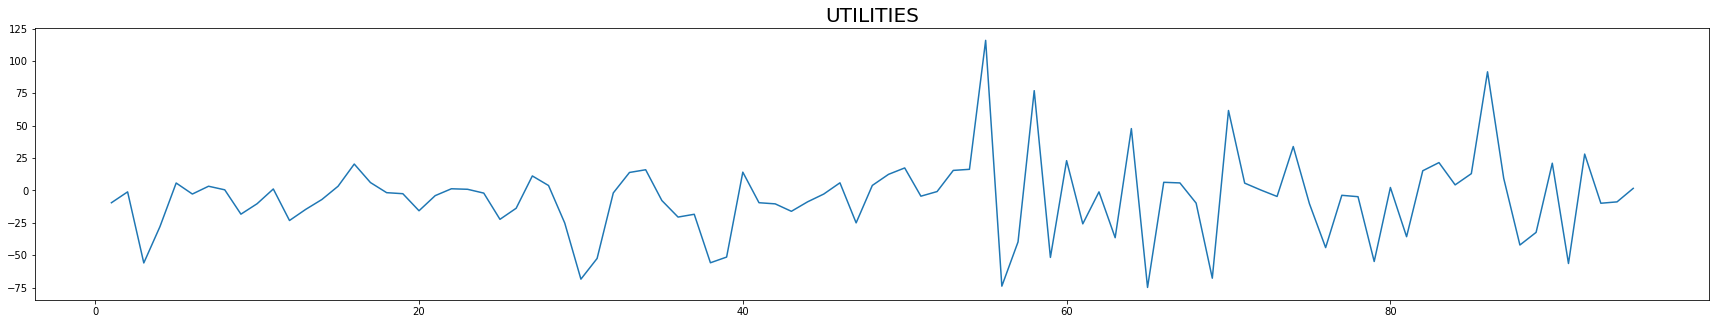

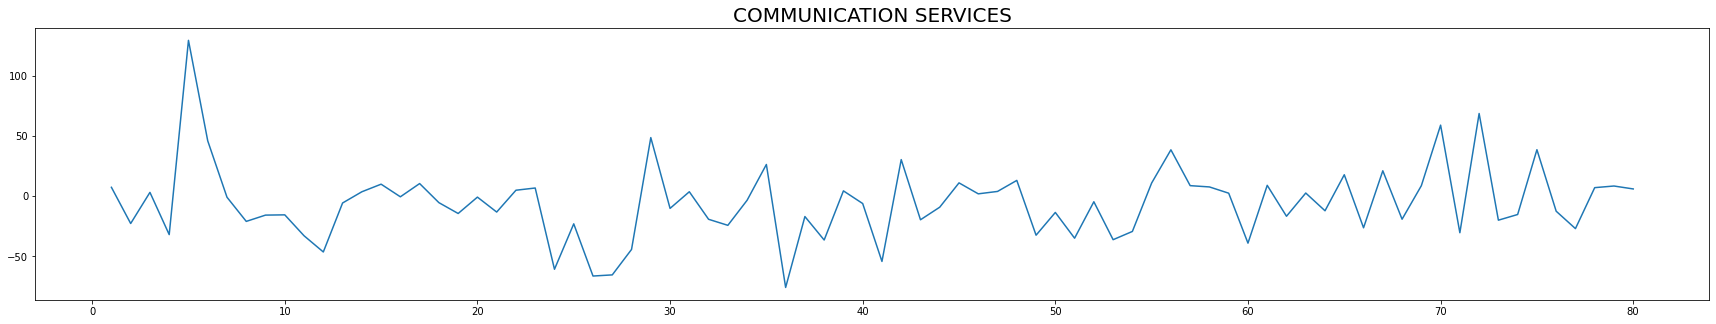

In [552]:
df_class = cleaned_df['Sector'].value_counts()
sectors = list(df_class.keys())
df_ = trimmed_fy_fi_df.loc[:, ['Sector', '2015 PRICE VAR [%]']]

for sector in sectors:
    
    temp = df_[df_['Sector'] == sector]
    
    x = [i+1 for i in range(len(temp))]
    plt.figure(figsize=(30,5))
    plt.plot(x,temp['2015 PRICE VAR [%]'])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

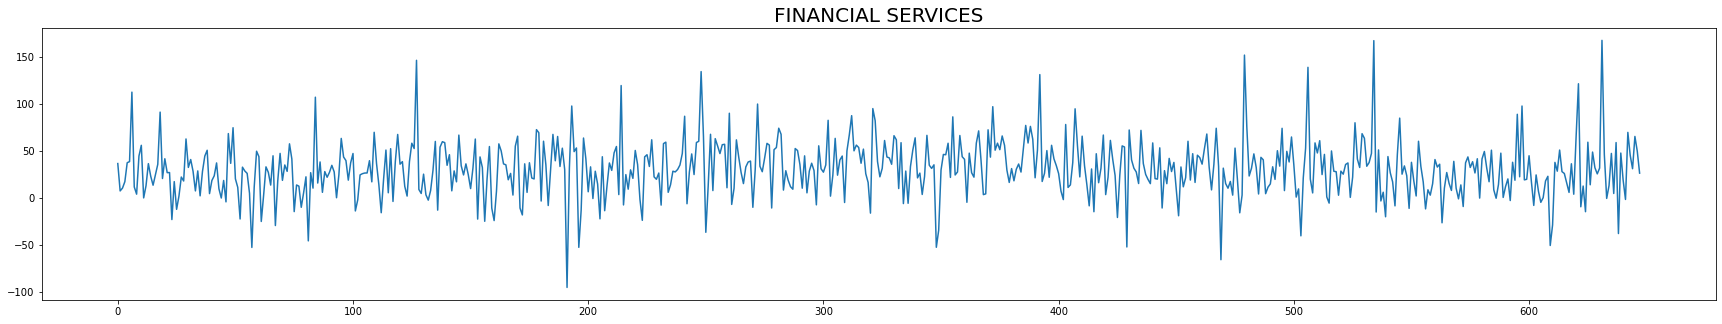

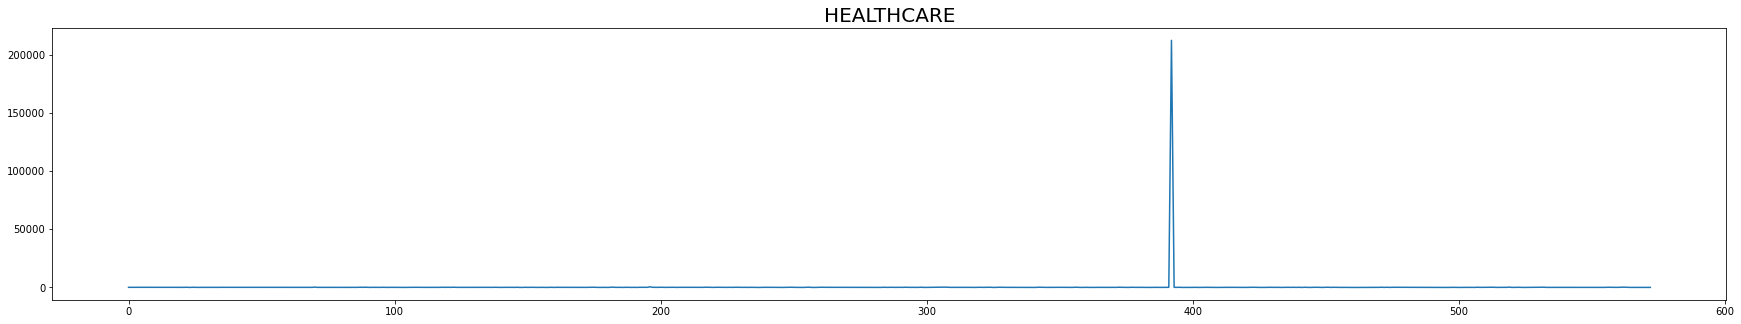

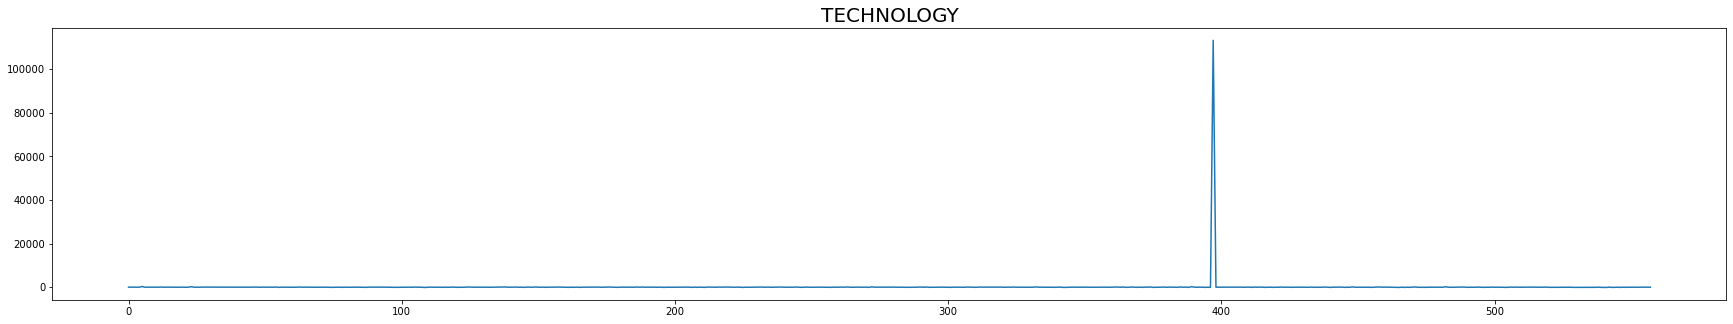

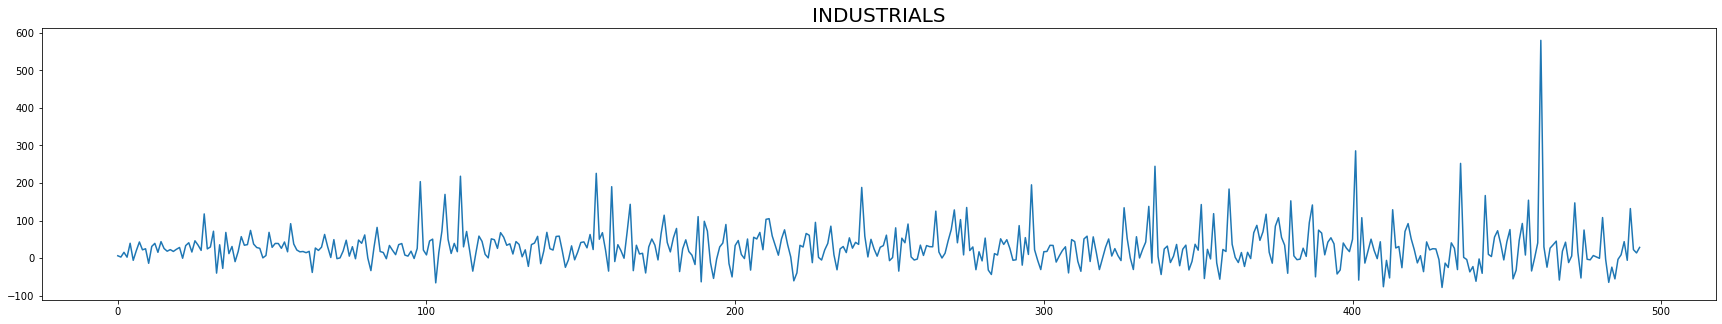

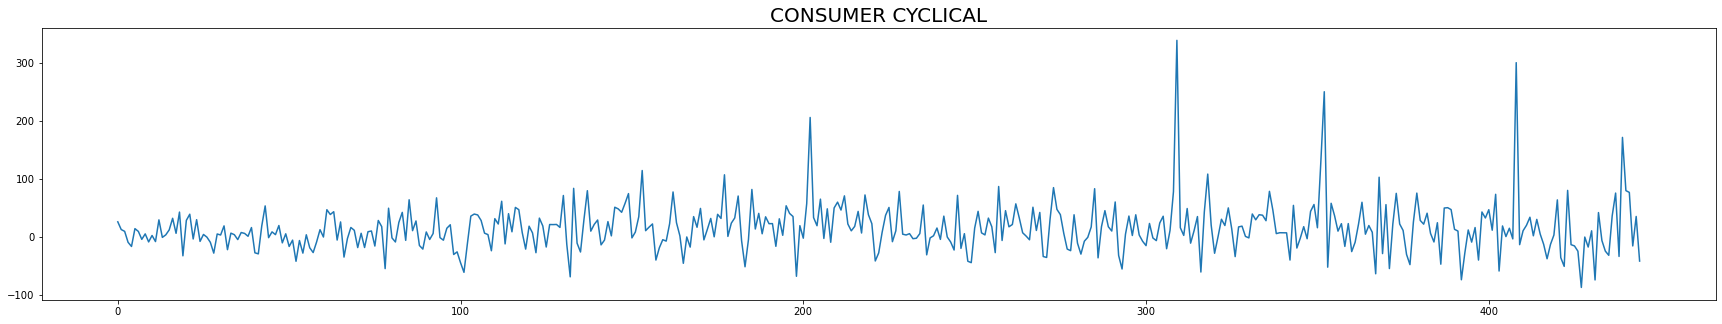

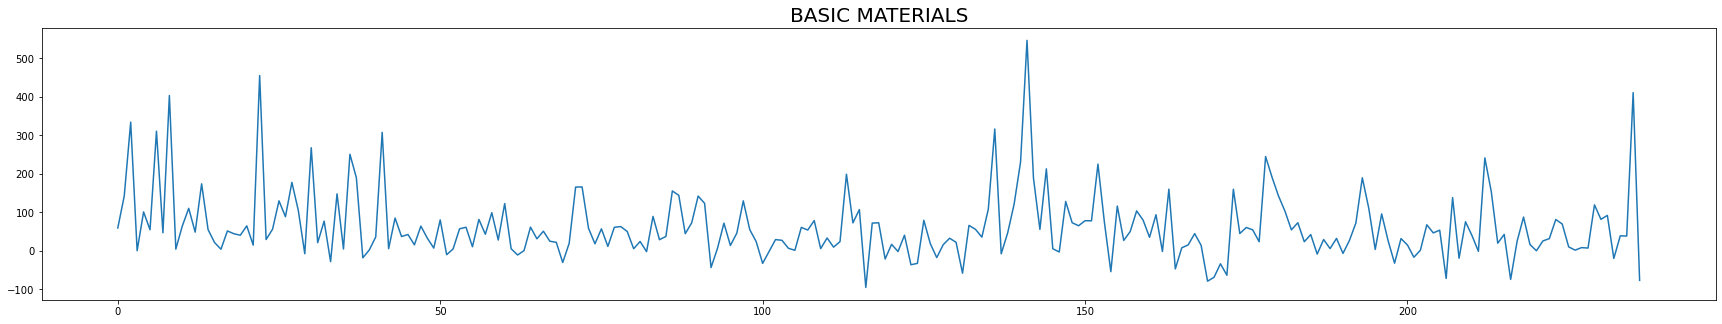

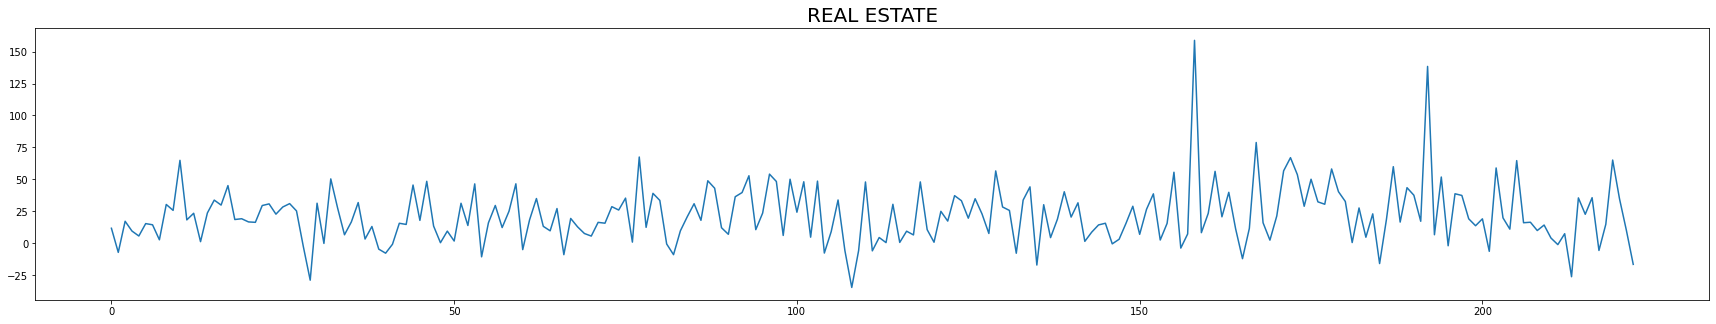

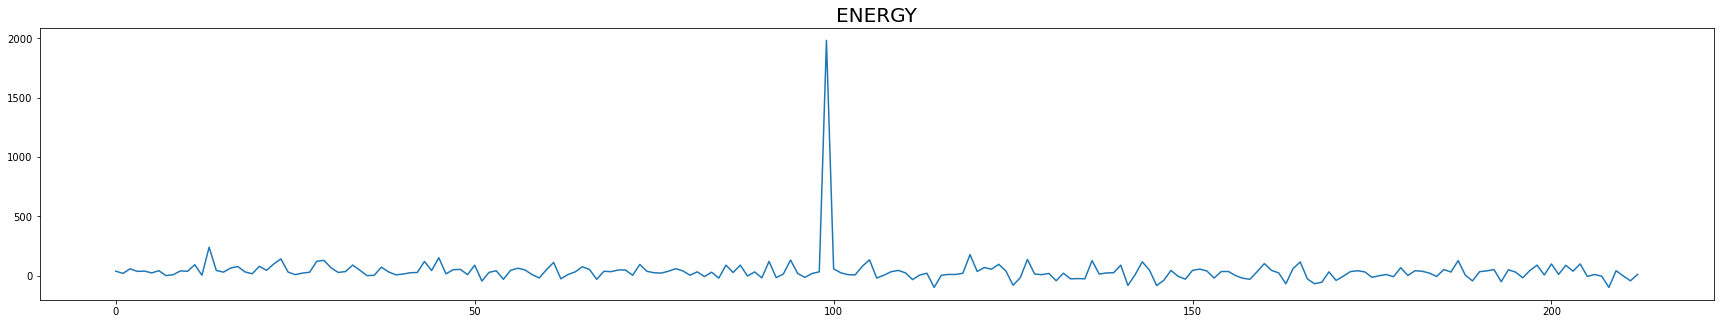

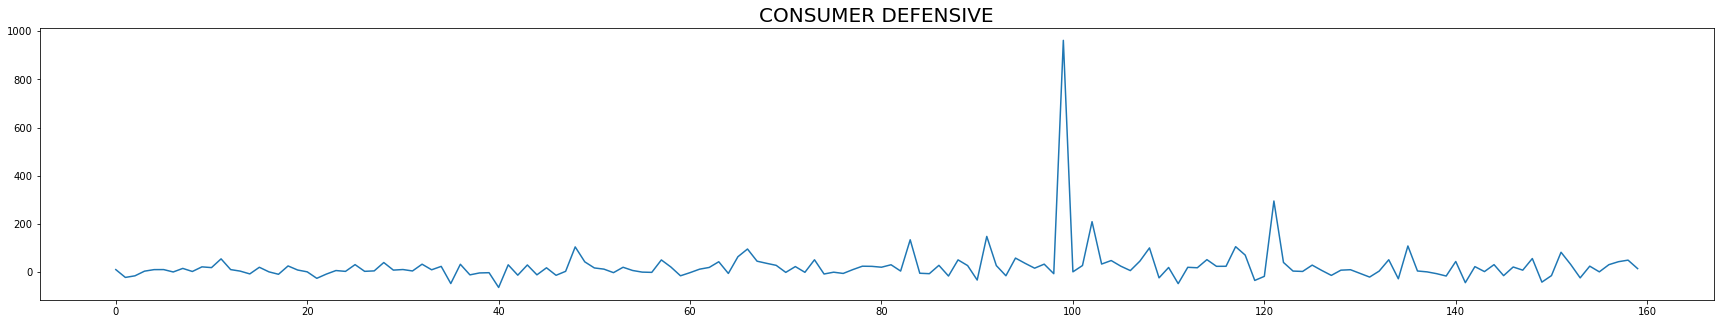

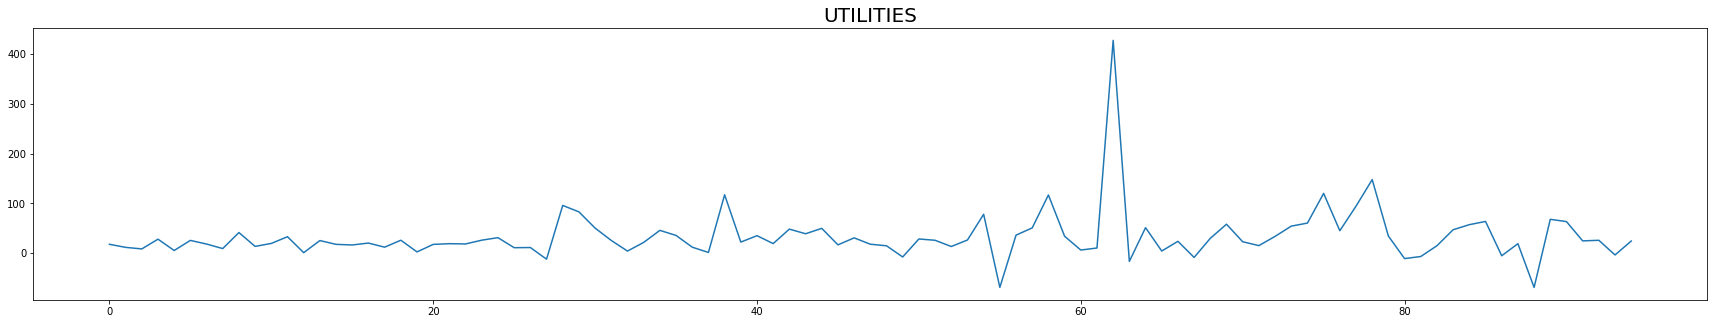

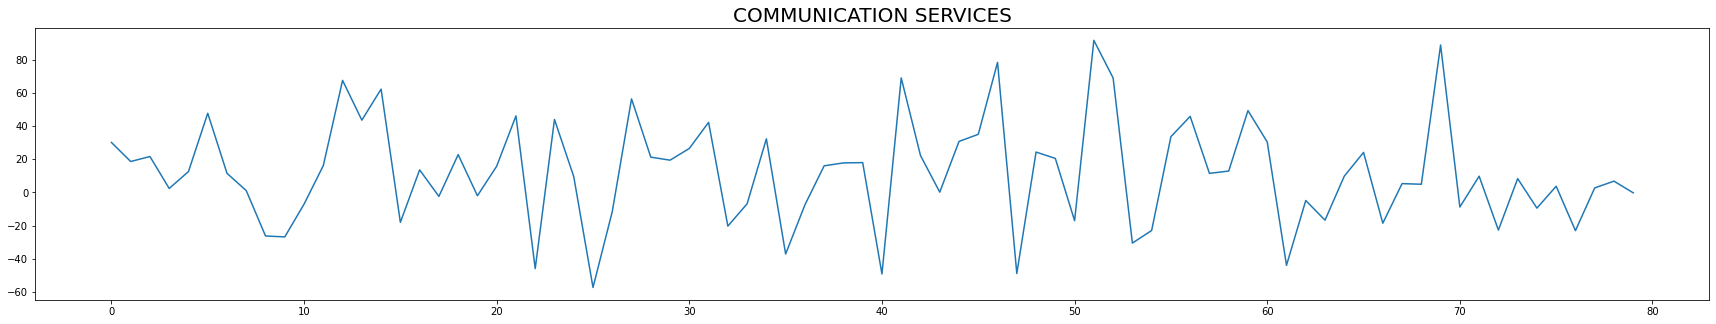

In [560]:
df_ = cleaned_df.loc[:, ['Sector', 'PRICE VAR [%]', 'Year']]

for sector in sectors:
    
    temp = df_[df_['Sector'] == sector]
    temp = temp[temp['Year'] == 2015]
    x = [i for i in range(len(temp))]

    plt.figure(figsize=(30,5))
    plt.plot(x,temp['PRICE VAR [%]'])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

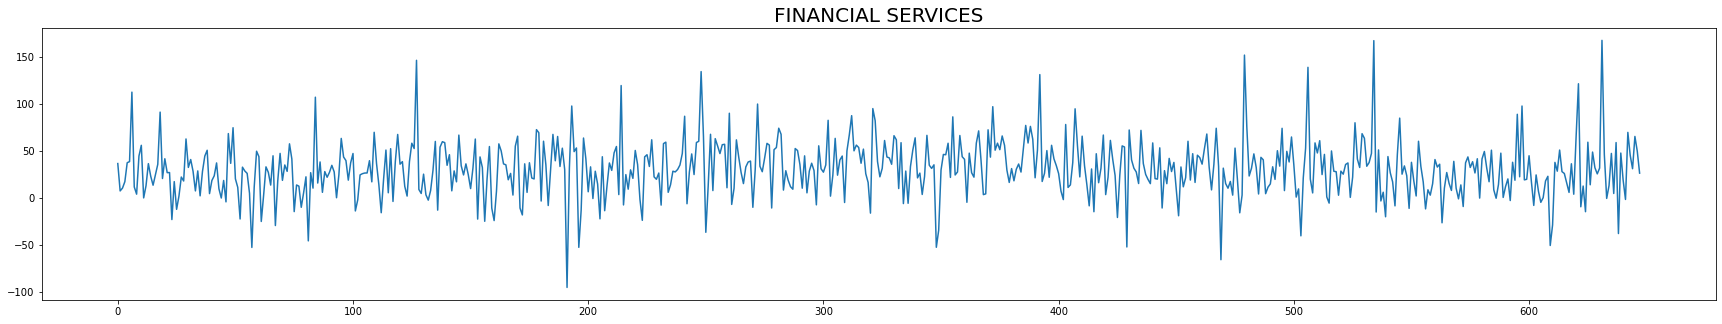

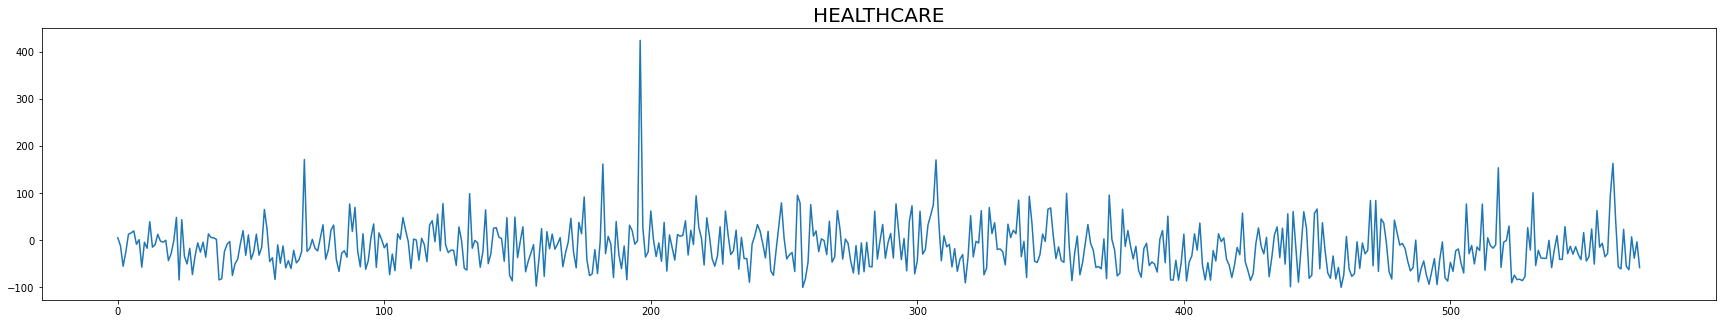

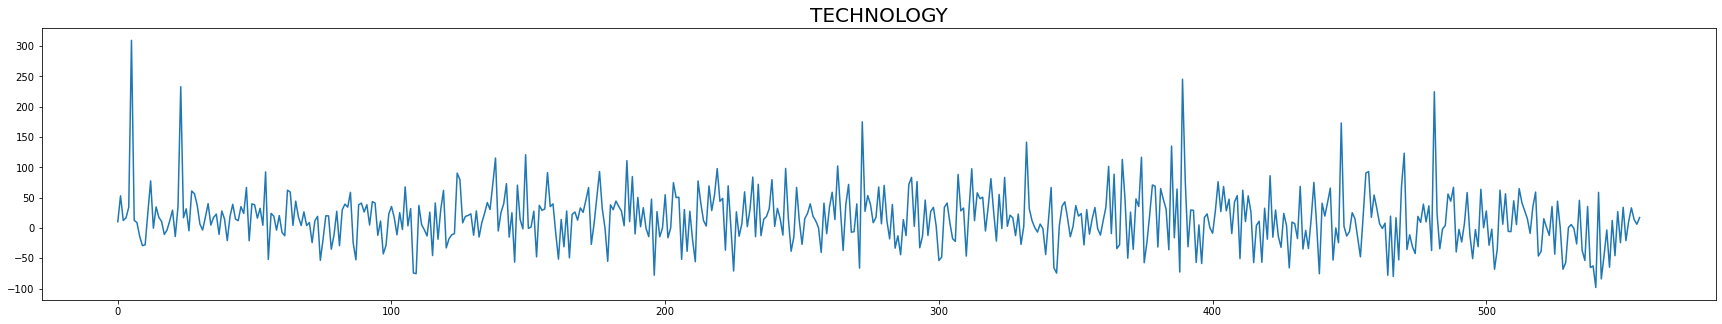

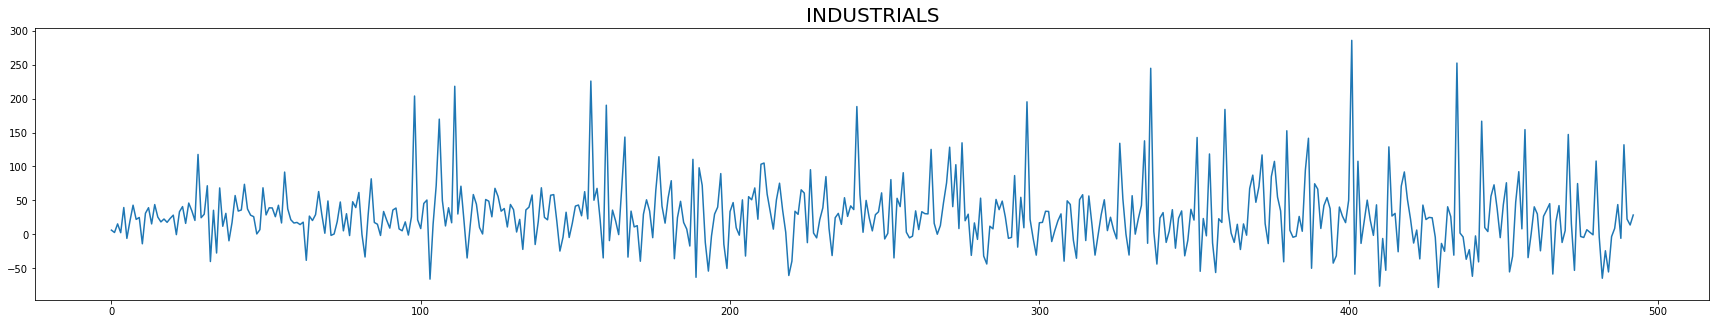

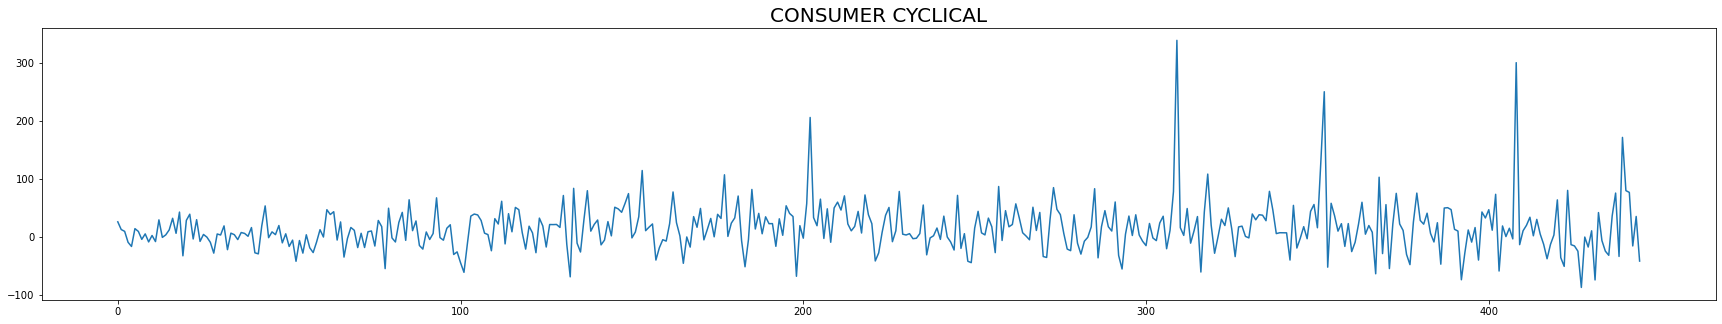

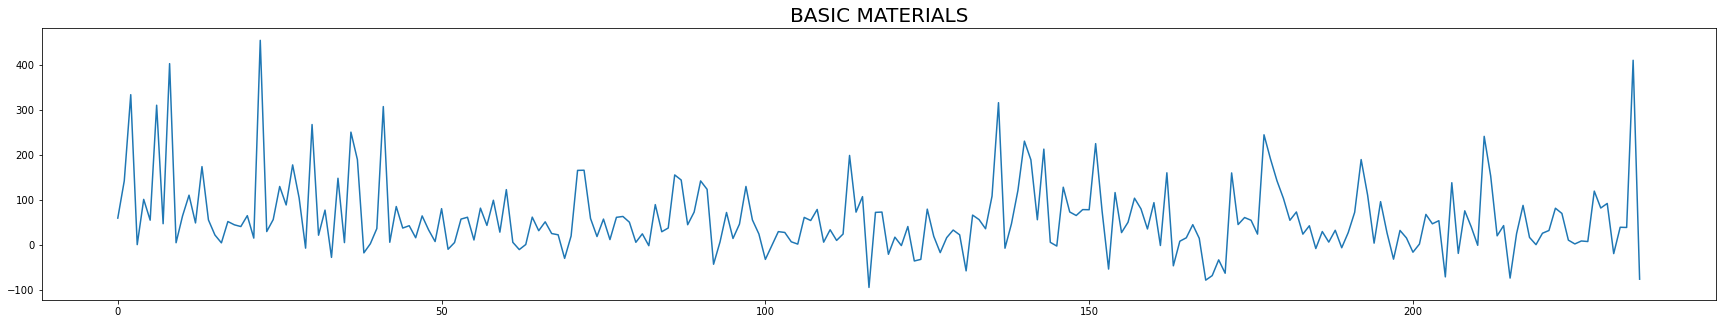

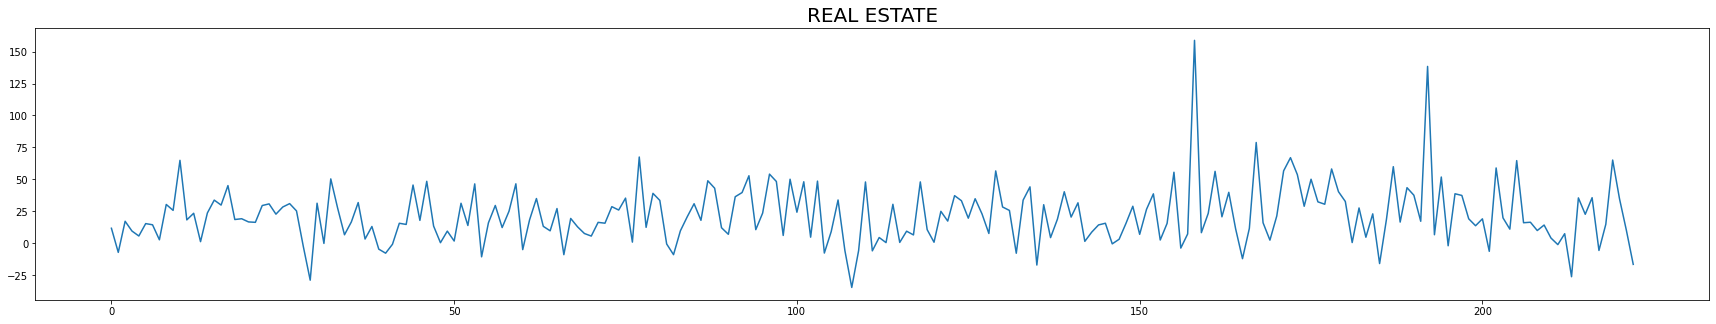

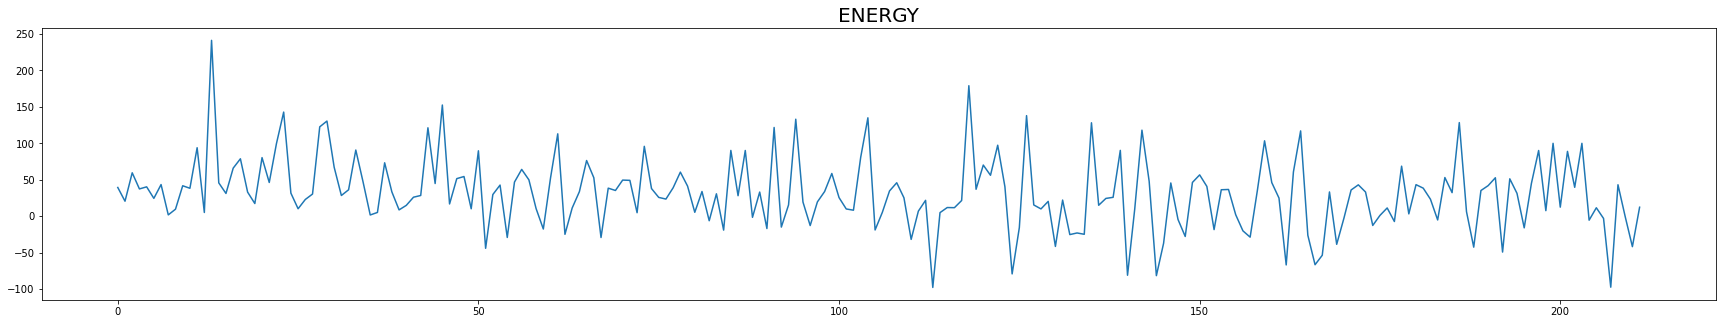

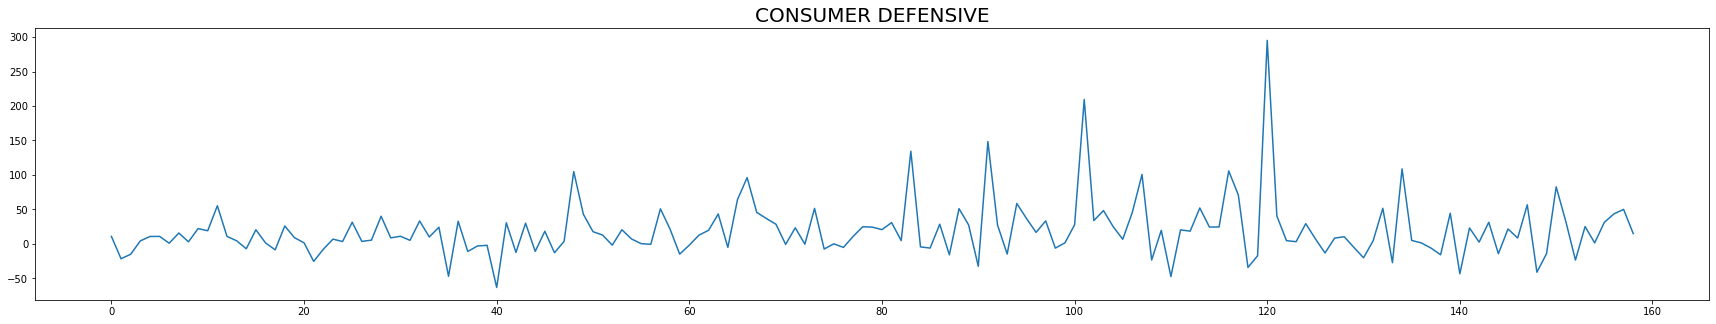

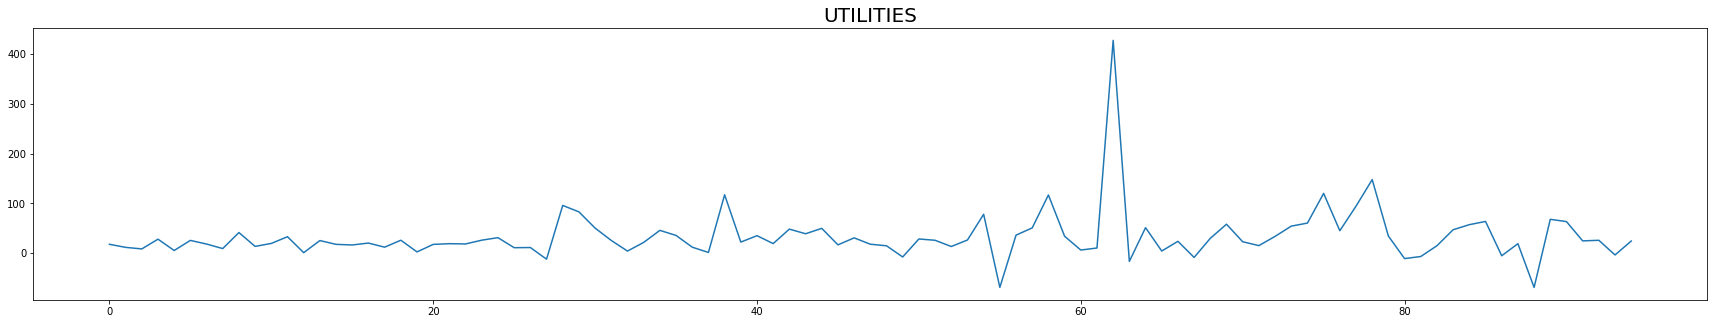

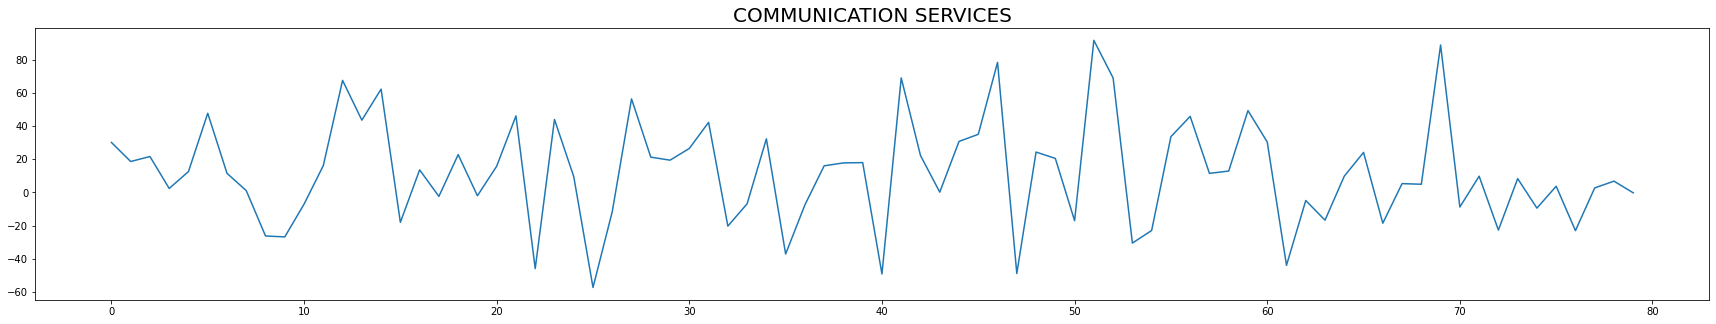

In [561]:

df_ = cleaned_df.loc[:, ['Sector', 'PRICE VAR [%]', 'Year']]

for sector in sectors:
    
    temp = df_[df_['Sector'] == sector]
    temp = temp[temp['Year'] == 2015]
    temp = temp[temp['PRICE VAR [%]'] < 500]
    x = [i for i in range(len(temp))]

    plt.figure(figsize=(30,5))
    plt.plot(x,temp['PRICE VAR [%]'])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

In [557]:
temp['PRICE VAR [%]']

2171      7.424300
2172    -22.628620
2173      3.222676
2174    -31.856374
2175    129.454914
           ...    
2249    -12.424848
2250    -26.876955
2251      7.143547
2252      8.497955
2253      6.065967
Name: PRICE VAR [%], Length: 80, dtype: float64

In [396]:
rest_features = ['EPS', 'Dividend per Share', 
       'cashRatio', 'Market Cap',
      'Enterprise Value over EBITDA',
       'EV to Operating cash flow', 'Earnings Yield', 'Free Cash Flow Yield',
       'Graham Number', 'Graham Net-Net', 'ROE',
       'Weighted Average Shares Growth',
       '5Y Revenue Growth (per Share)', '3Y Revenue Growth (per Share)', 'Year']

In [397]:
selected_features = numeric_data[rest_features]

In [398]:
final_features = pd.concat([selected_features,cat_2],axis = 1)

In [399]:
df = pd.concat([final_features,Y_1],axis = 1)

In [400]:

df_class = cleaned_df['Sector'].value_counts()
sectors = list(df_class.keys())
df_sectors = []

for i in range(len(sectors)):
    df_sectors.append(df[df['Sector'] == sectors[i]])
    


In [401]:
from sklearn.model_selection import train_test_split

cat_columns = ['Class', 'Sector']

clf_scores = np.zeros((3,len(sectors)))
f1_scores = np.zeros((3,len(sectors)))

classifiers = [LogisticRegression(random_state=0), DecisionTreeClassifier(), RandomForestClassifier()]

for i in range(len(sectors)):
    
    train, test = train_test_split(df_sectors[i], test_size=0.2)
    
    train_x = train.loc[:, ~train.columns.isin(cat_columns)]
    train_y = train[['Class']]
    test_x = test.loc[:, ~test.columns.isin(cat_columns)]
    test_y = test[['Class']]
    
    train_x_np = np.asarray(train_x)
    test_x_np = np.asarray(test_x)
    train_y_np = np.asarray(train_y)
    test_y_np = np.asarray(test_y)
    
    x,s,m = normalize(train_x_np[:,:])
    x_test,_,_ = normalize(test_x_np[:,:],s,m)
    
    #train_x_np = np.concatenate((x,train_x_np),axis = 1)
    #test_x_np = np.concatenate((x_test,test_x_np),axis = 1)
    
    train_x_np = x
    test_x_np = x_test
    
    
    for j in range(len(classifiers)):
        clf = classifiers[j].fit(train_x_np, train_y_np)
        score = clf.score(test_x_np, test_y_np)

        y_pred = clf.predict(test_x_np)
        f1 = f1_score(test_y_np, y_pred, average='weighted')
    
        clf_scores[j,i] = score
        f1_scores[j,i] = f1
    


C:\Users\sukri\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-401-752ac6c0f98e>:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = classifiers[j].fit(train_x_np, train_y_np)
C:\Users\sukri\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-401-752ac6c0f98e>:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = classifiers[j].fit(train_x_

In [402]:
df_clf_scores = pd.DataFrame(data=clf_scores, index=["Logistic Regression","Decision Tree", "Random Forest"], columns=sectors)
df_clf_scores

,Financial Services,Healthcare,Technology,Industrials,Consumer Cyclical,Basic Materials,Real Estate,Energy,Consumer Defensive,Utilities,Communication Services
Logistic Regression,0.651235,0.663176,0.591398,0.574899,0.521348,0.552743,0.623318,0.596244,0.65625,0.726316,0.5375
Decision Tree,0.671296,0.586387,0.600358,0.613360,0.516854,0.628692,0.668161,0.657277,0.61875,0.652632,0.5375
Random Forest,0.740741,0.619546,0.621864,0.661943,0.626966,0.675105,0.730942,0.694836,0.63750,0.673684,0.6000


In [403]:
df_f1_scores = pd.DataFrame(data=f1_scores, index=["Logistic Regression","Decision Tree", "Random Forest"], columns=sectors)
df_f1_scores

,Financial Services,Healthcare,Technology,Industrials,Consumer Cyclical,Basic Materials,Real Estate,Energy,Consumer Defensive,Utilities,Communication Services
Logistic Regression,0.559896,0.657510,0.551887,0.546218,0.503036,0.543078,0.523655,0.534823,0.631158,0.657069,0.531883
Decision Tree,0.670498,0.587909,0.599127,0.612510,0.516707,0.628692,0.668943,0.657046,0.625786,0.650760,0.539029
Random Forest,0.728900,0.614935,0.610585,0.659623,0.625097,0.674040,0.721482,0.681247,0.636080,0.638786,0.601010


In [ ]:
df_ = cleaned_df.loc[:, ['Sector', 'PRICE VAR [%]']]

sector_list = df_['Sector'].unique()

for sector in sector_list:
    
    temp = df_[df_['Sector'] == sector]

    x=[i for i in range(1, len(temp)+1)]
    plt.figure(figsize=(30,5))
    plt.plot(x,temp['PRICE VAR [%]'])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

In [ ]:
from pandas_datareader import data
import datetime    


# Get stocks that increased more than 500%
gain = 500
top_gainers = cleaned_df[cleaned_df['PRICE VAR [%]'] >= gain]
top_gainers = top_gainers['PRICE VAR [%]'].sort_values(ascending=False)



print(len(top_gainers))

print(type(top_gainers))

'''
print(f'{len(top_gainers)} STOCKS with more than {gain}% gain.')
print()

# Set
date_start = '01-01-2015'
date_end = '12-31-2015'
tickers = top_gainers.index.values.tolist()

for ticker in tickers:
    
    # Pull daily prices for each ticker from Yahoo Finance
    daily_price = data.DataReader(ticker, 'yahoo', date_start, date_end)
    
    # Plot prices with volume
    fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
    
    ax0.plot(daily_price['Adj Close'])
    ax0.set_title(ticker, fontsize=18)
    ax0.set_ylabel('Daily Adj Close $', fontsize=14)
    ax1.plot(daily_price['Volume'])
    ax1.set_ylabel('Volume', fontsize=14)
    ax1.yaxis.set_major_formatter(
            matplotlib.ticker.StrMethodFormatter('{x:.0E}'))

    fig.align_ylabels(ax1)
    fig.tight_layout()
    plt.show()
    
'''

In [ ]:
cleaned_df_organic = cleaned_df
index_inorganic = top_gainers.index.values
cleaned_df_organic.drop(index_inorganic, axis=0, inplace=True)

In [ ]:
cleaned_df_organic

In [ ]:
top_gainers.index.values

In [ ]:
df_ = cleaned_df_organic.loc[:, ['Sector', 'PRICE VAR [%]']]

sector_list = df_['Sector'].unique()

for sector in sector_list:
    
    temp = df_[df_['Sector'] == sector]

    x=[i for i in range(1, len(temp)+1)]
    plt.figure(figsize=(30,5))
    plt.plot(x,temp['PRICE VAR [%]'])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

In [ ]:
temp

In [ ]:
len(temp)

In [ ]:
trimmed_fy_fi_df
df_ = trimmed_fy_fi_df.loc[:, ['Sector', '2015 PRICE VAR [%]']]

sector_list = df_['Sector'].unique()

for sector in sector_list:
    
    temp = df_[df_['Sector'] == sector]

    x=[i for i in range(1, len(temp)+1)]
    plt.figure(figsize=(30,5))
    plt.plot(x,temp['2015 PRICE VAR [%]'])
    plt.title(sector.upper(), fontsize=20)
    plt.show()


In [341]:
relevant_features.index

Index(['Year', 'Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       '3Y Shareholders Equity Growth (per Share)',
       '5Y Dividend per Share Growth (per Share)',
       '3Y Dividend per Share Growth (per Share)', 'Receivables growth',
       'Inventory Growth', 'Asset Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth', 'Class'],
      dtype='object', length=169)

In [406]:
rest_features = ['EPS', 'Dividend per Share', 
       'cashRatio', 'Market Cap',
      'Enterprise Value over EBITDA',
       'EV to Operating cash flow', 'Earnings Yield', 'Free Cash Flow Yield',
       'Graham Number', 'Graham Net-Net', 'ROE',
       'Weighted Average Shares Growth',
       '5Y Revenue Growth (per Share)', '3Y Revenue Growth (per Share)', 'Year']

In [407]:
selected_features = numeric_data[relevant_features.index[:-1]]
selected_features.shape

(18630, 168)

In [408]:
final_features = pd.concat([selected_features,cat_2],axis = 1)
final_features.shape

(18630, 169)

In [409]:
df = pd.concat([final_features,Y_1],axis = 1)

In [410]:
df_class = cleaned_df['Sector'].value_counts()
sectors = list(df_class.keys())
df_sectors = []

for i in range(len(sectors)):
    df_sectors.append(df[df['Sector'] == sectors[i]])
    

In [390]:
from sklearn.model_selection import train_test_split

cat_columns = ['Class', 'Sector']

clf_scores = np.zeros((3,len(sectors)))
f1_scores = np.zeros((3,len(sectors)))

classifiers = [LogisticRegression(random_state=0), DecisionTreeClassifier(), RandomForestClassifier()]

for i in range(len(sectors)):
    
    train, test = train_test_split(df_sectors[i], test_size=0.2)
    
    train_x = train.loc[:, ~train.columns.isin(cat_columns)]
    train_y = train[['Class']]
    test_x = test.loc[:, ~test.columns.isin(cat_columns)]
    test_y = test[['Class']]
    
    train_x_np = np.asarray(train_x)
    test_x_np = np.asarray(test_x)
    train_y_np = np.asarray(train_y)
    test_y_np = np.asarray(test_y)
    
    x,s,m = normalize(train_x_np[:,:])
    x_test,_,_ = normalize(test_x_np[:,:],s,m)
    
    #train_x_np = np.concatenate((x,train_x_np),axis = 1)
    #test_x_np = np.concatenate((x_test,test_x_np),axis = 1)
    
    train_x_np = np.where(x==np.inf, 0, x)
    train_x_np = np.where(np.isnan(train_x_np), 0, train_x_np)
    test_x_np = np.where(x_test==np.inf, 0, x_test)
    test_x_np = np.where(np.isnan(test_x_np), 0, test_x_np)
    
    train_x_np = train_x_np.astype(np.float64)
    test_x_np = test_x_np.astype(np.float64)
    
    
    for j in range(len(classifiers)):
        clf = classifiers[j].fit(train_x_np, train_y_np)
        score = clf.score(test_x_np, test_y_np)

        y_pred = clf.predict(test_x_np)
        f1 = f1_score(test_y_np, y_pred, average='weighted')
    
        clf_scores[j,i] = score
        f1_scores[j,i] = f1
    


<ipython-input-223-b2dcb9856da2>:5: RuntimeWarning: invalid value encountered in true_divide
  x = (x-m)/s
C:\Users\sukri\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sukri\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-390-c481708a1409>:40: DataConversionWarning: A column-vector y was passed when a 1d array was expec

<ipython-input-223-b2dcb9856da2>:5: RuntimeWarning: invalid value encountered in true_divide
  x = (x-m)/s
C:\Users\sukri\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sukri\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-390-c481708a1409>:40: DataConversionWarning: A column-vector y was passed when a 1d array was expec

In [391]:
df_clf_scores = pd.DataFrame(data=clf_scores, index=["Logistic Regression","Decision Tree", "Random Forest"], columns=sectors)
df_clf_scores


,Financial Services,Healthcare,Technology,Industrials,Consumer Cyclical,Basic Materials,Real Estate,Energy,Consumer Defensive,Utilities,Communication Services
Logistic Regression,0.712963,0.621291,0.630824,0.595142,0.588764,0.540084,0.627803,0.610329,0.52500,0.642105,0.4875
Decision Tree,0.671296,0.596859,0.584229,0.625506,0.595506,0.607595,0.654709,0.661972,0.48125,0.600000,0.5875
Random Forest,0.725309,0.609075,0.594982,0.605263,0.613483,0.599156,0.636771,0.708920,0.53125,0.736842,0.5375


In [392]:

df_f1_scores = pd.DataFrame(data=f1_scores, index=["Logistic Regression","Decision Tree", "Random Forest"], columns=sectors)
df_f1_scores

,Financial Services,Healthcare,Technology,Industrials,Consumer Cyclical,Basic Materials,Real Estate,Energy,Consumer Defensive,Utilities,Communication Services
Logistic Regression,0.686310,0.612890,0.619876,0.590837,0.588810,0.535905,0.607057,0.613699,0.507383,0.666784,0.486297
Decision Tree,0.673258,0.597231,0.584229,0.624841,0.593732,0.607553,0.655211,0.668903,0.479155,0.633556,0.583408
Random Forest,0.706419,0.599216,0.581105,0.601985,0.610966,0.599013,0.611811,0.691646,0.515238,0.728111,0.537283


In [395]:
test_x_np.shape

(80, 168)

In [393]:
train_x_np

array([[ 0.00883918,  0.47159759, -0.14540994, ..., -0.2419124 ,
        -0.27364986, -0.18918617],
       [ 0.71597358, -0.56908986, -0.29449175, ..., -0.1148786 ,
        -0.27364986, -0.57450877],
       [ 0.00883918, -0.52102903,  2.25559191, ...,  0.30154959,
        -0.27364986,  2.31290042],
       ...,
       [ 0.71597358, -0.24772898, -0.12514004, ..., -0.30114726,
        -0.27364986, -0.22495716],
       [-1.40542963,  1.3135424 , -0.37491747, ..., -0.43674513,
        -0.27364986, -0.5820395 ],
       [ 0.00883918, -0.54770058, -0.19771935, ..., -0.25582902,
        -0.27364986, -0.53622753]])

In [389]:
relevant_features.index

Index(['Year', 'Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       '3Y Shareholders Equity Growth (per Share)',
       '5Y Dividend per Share Growth (per Share)',
       '3Y Dividend per Share Growth (per Share)', 'Receivables growth',
       'Inventory Growth', 'Asset Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth', 'Class'],
      dtype='object', length=169)

## Class distribution among sectors

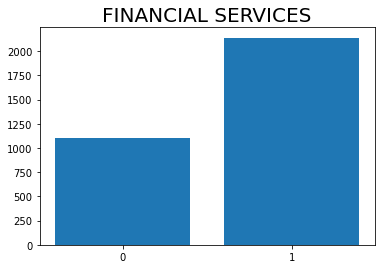

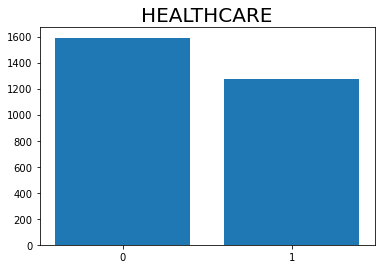

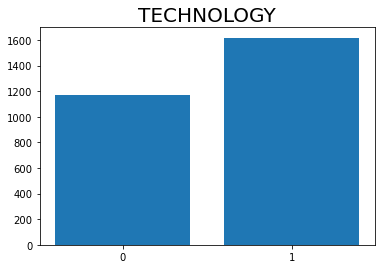

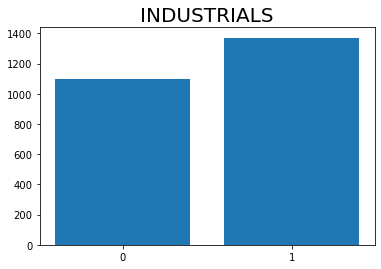

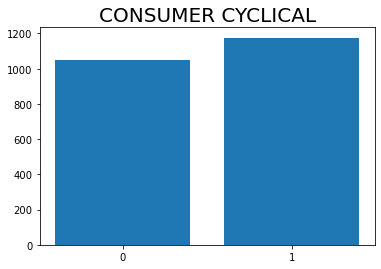

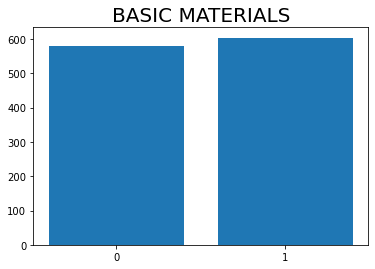

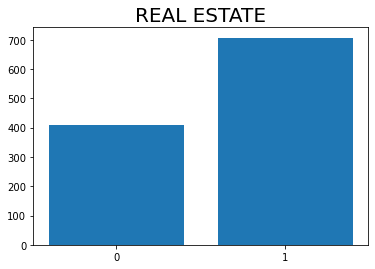

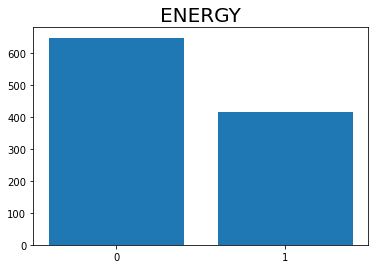

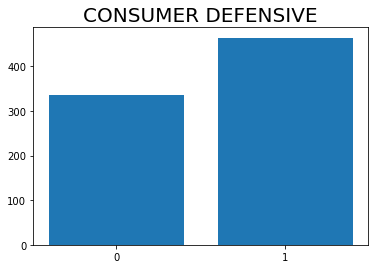

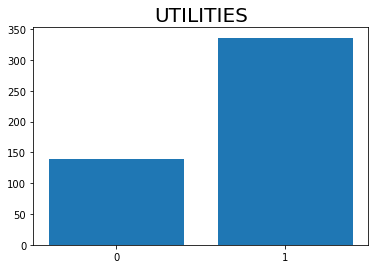

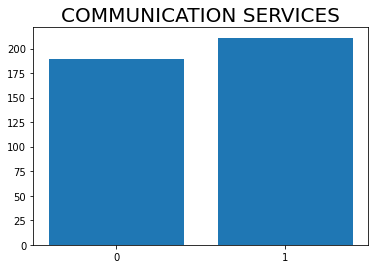

In [562]:
for i in range(len(sectors)):
    df_class = df_sectors[i]['Class'].value_counts()
    plt.bar(df_class.keys(), df_class)
    plt.xticks(df_class.keys())
    plt.title(sectors[i].upper(), fontsize=20)
    plt.show()

In [413]:
from sklearn.model_selection import train_test_split

cat_columns = ['Class', 'Sector']

clf_scores = np.zeros((3,len(sectors)))
f1_scores = np.zeros((3,len(sectors)))

classifiers = [LogisticRegression(random_state=0), DecisionTreeClassifier(), RandomForestClassifier()]

for i in range(len(sectors)):
    
    train, test = train_test_split(df_sectors[i], test_size=0.2, stratify=df_sectors[i]['Class'])
    
    train_x = train.loc[:, ~train.columns.isin(cat_columns)]
    train_y = train[['Class']]
    test_x = test.loc[:, ~test.columns.isin(cat_columns)]
    test_y = test[['Class']]
    
    train_x_np = np.asarray(train_x)
    test_x_np = np.asarray(test_x)
    train_y_np = np.asarray(train_y)
    test_y_np = np.asarray(test_y)
    
    x,s,m = normalize(train_x_np[:,:])
    x_test,_,_ = normalize(test_x_np[:,:],s,m)
    
    #train_x_np = np.concatenate((x,train_x_np),axis = 1)
    #test_x_np = np.concatenate((x_test,test_x_np),axis = 1)
    
    train_x_np = np.where(x==np.inf, 0, x)
    train_x_np = np.where(np.isnan(train_x_np), 0, train_x_np)
    test_x_np = np.where(x_test==np.inf, 0, x_test)
    test_x_np = np.where(np.isnan(test_x_np), 0, test_x_np)
    
    train_x_np = train_x_np.astype(np.float64)
    test_x_np = test_x_np.astype(np.float64)
    
    
    for j in range(len(classifiers)):
        clf = classifiers[j].fit(train_x_np, train_y_np)
        score = clf.score(test_x_np, test_y_np)

        y_pred = clf.predict(test_x_np)
        f1 = f1_score(test_y_np, y_pred, average='weighted')
    
        clf_scores[j,i] = score
        f1_scores[j,i] = f1
    


<ipython-input-223-b2dcb9856da2>:5: RuntimeWarning: invalid value encountered in true_divide
  x = (x-m)/s
C:\Users\sukri\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sukri\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-413-c5c630809d7b>:40: DataConversionWarning: A column-vector y was passed when a 1d array was expec

<ipython-input-223-b2dcb9856da2>:5: RuntimeWarning: invalid value encountered in true_divide
  x = (x-m)/s
C:\Users\sukri\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sukri\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-413-c5c630809d7b>:40: DataConversionWarning: A column-vector y was passed when a 1d array was expec

In [414]:
df_clf_scores = pd.DataFrame(data=clf_scores, index=["Logistic Regression","Decision Tree", "Random Forest"], columns=sectors)
df_clf_scores


,Financial Services,Healthcare,Technology,Industrials,Consumer Cyclical,Basic Materials,Real Estate,Energy,Consumer Defensive,Utilities,Communication Services
Logistic Regression,0.662037,0.614311,0.616487,0.580972,0.595506,0.582278,0.641256,0.666667,0.55000,0.694737,0.5000
Decision Tree,0.662037,0.567190,0.600358,0.625506,0.579775,0.691983,0.663677,0.647887,0.51875,0.736842,0.5375
Random Forest,0.714506,0.623037,0.603943,0.643725,0.568539,0.603376,0.618834,0.671362,0.53125,0.684211,0.5250


In [415]:

df_f1_scores = pd.DataFrame(data=f1_scores, index=["Logistic Regression","Decision Tree", "Random Forest"], columns=sectors)
df_f1_scores

,Financial Services,Healthcare,Technology,Industrials,Consumer Cyclical,Basic Materials,Real Estate,Energy,Consumer Defensive,Utilities,Communication Services
Logistic Regression,0.627536,0.599087,0.604140,0.578855,0.593370,0.578852,0.622603,0.649972,0.541505,0.693092,0.495238
Decision Tree,0.662587,0.563744,0.599998,0.626477,0.578929,0.691906,0.666280,0.647495,0.517059,0.742527,0.535980
Random Forest,0.693222,0.610691,0.586942,0.639936,0.567098,0.602908,0.600076,0.659076,0.523377,0.646515,0.524104


In [421]:
def compare(df1, df2):
    
    np1 = np.asarray(df1)
    np2 = np.asarray(df2)
    np_compare = np.zeros((3,len(sectors)))
    
    for i in range(len(sectors)):
        for j in range(len(models)):
            if np1[j,i] > np2[j,i]:
                np_compare[j,i] = 1
            else:
                np_compare[j,i] = 2
    
    
    df_compare = pd.DataFrame(data=np.compare, index=["Logistic Regression","Decision Tree", "Random Forest"], columns=sectors)             
    print(df_compare)
    return None

# Temporal

In [422]:




from sklearn.model_selection import train_test_split

cat_columns = ['Class', 'Sector']
target = df[['Class','Year']]
#price_columns = ['Class']
data = df.loc[:, ~df.columns.isin(cat_columns)]

clf_scores = np.zeros((3,len(sectors)))
f1_scores = np.zeros((3,len(sectors)))

classifiers = [LogisticRegression(random_state=0), DecisionTreeClassifier(), RandomForestClassifier()]

for i in range(len(sectors)):
    
    # the following variable records the features of examples in the training set
    train_x_df = data.loc[data['Year'] != 2018]
    train_x = train_x_df.loc[:, ~train_x_df.columns.isin(['Year'])]
    # the following variable records the features of examples in the test set
    test_x_df = data.loc[data['Year'] == 2018]
    test_x = test_x_df.loc[:, ~test_x_df.columns.isin(['Year'])]
    # the following variable records the labels of examples in the training set
    train_y_df = target.loc[data['Year'] != 2018]
    train_y = train_y_df.loc[:, ~train_y_df.columns.isin(['Year'])]
    # the following variable records the labels of examples in the test set
    test_y_df = target.loc[data['Year'] == 2018]
    test_y = test_y_df.loc[:, ~test_y_df.columns.isin(['Year'])]
    
    train_x_np = np.asarray(train_x)
    test_x_np = np.asarray(test_x)
    train_y_np = np.asarray(train_y)
    test_y_np = np.asarray(test_y)
    
    x,s,m = normalize(train_x_np[:,:])
    x_test,_,_ = normalize(test_x_np[:,:],s,m)
    
    #train_x_np = np.concatenate((x,train_x_np),axis = 1)
    #test_x_np = np.concatenate((x_test,test_x_np),axis = 1)
    
    train_x_np = np.where(x==np.inf, 0, x)
    train_x_np = np.where(np.isnan(train_x_np), 0, train_x_np)
    test_x_np = np.where(x_test==np.inf, 0, x_test)
    test_x_np = np.where(np.isnan(test_x_np), 0, test_x_np)
    
    train_x_np = train_x_np.astype(np.float64)
    test_x_np = test_x_np.astype(np.float64)
    
    
    for j in range(len(classifiers)):
        clf = classifiers[j].fit(train_x_np, train_y_np)
        score = clf.score(test_x_np, test_y_np)

        y_pred = clf.predict(test_x_np)
        f1 = f1_score(test_y_np, y_pred, average='weighted')
    
        clf_scores[j,i] = score
        f1_scores[j,i] = f1
    


C:\Users\sukri\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sukri\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-422-196042d69fb7>:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = classifiers[j].fit(tr

C:\Users\sukri\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-422-196042d69fb7>:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = classifiers[j].fit(train_x_np, train_y_np)
C:\Users\sukri\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colum

In [425]:
df_clf_scores = pd.DataFrame(data=clf_scores, index=["Logistic Regression","Decision Tree", "Random Forest"], columns=sectors)
df_clf_scores


,Financial Services,Healthcare,Technology,Industrials,Consumer Cyclical,Basic Materials,Real Estate,Energy,Consumer Defensive,Utilities,Communication Services
Logistic Regression,0.635534,0.635534,0.635534,0.635534,0.635534,0.635534,0.635534,0.635534,0.635534,0.635534,0.635534
Decision Tree,0.540794,0.549383,0.548041,0.553677,0.552872,0.552872,0.548846,0.541600,0.544552,0.552335,0.542136
Random Forest,0.602254,0.612453,0.611648,0.616210,0.609769,0.608964,0.610038,0.608696,0.608964,0.609769,0.604402


In [426]:

df_f1_scores = pd.DataFrame(data=f1_scores, index=["Logistic Regression","Decision Tree", "Random Forest"], columns=sectors)
df_f1_scores

,Financial Services,Healthcare,Technology,Industrials,Consumer Cyclical,Basic Materials,Real Estate,Energy,Consumer Defensive,Utilities,Communication Services
Logistic Regression,0.647685,0.647685,0.647685,0.647685,0.647685,0.647685,0.647685,0.647685,0.647685,0.647685,0.647685
Decision Tree,0.559536,0.567782,0.566479,0.571738,0.571034,0.571050,0.567294,0.560290,0.563107,0.570542,0.560793
Random Forest,0.618493,0.628202,0.627396,0.631872,0.625647,0.624884,0.625953,0.624700,0.624958,0.625582,0.620560


In [427]:
len(sectors)

11

# K Fold


In [450]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=None, shuffle=True)
for trn,tst in kf.split(cleaned_df):
    print("tst",tst)
    print("trn",trn)

tst [    0     5     6 ... 18619 18621 18622]
trn [    1     2     3 ... 18627 18628 18629]
tst [    2     8    10 ... 18620 18625 18627]
trn [    0     1     3 ... 18626 18628 18629]
tst [    3     4     9 ... 18599 18618 18626]
trn [    0     1     2 ... 18627 18628 18629]
tst [   22    25    29 ... 18610 18617 18629]
trn [    0     1     2 ... 18626 18627 18628]
tst [    1     7    14 ... 18623 18624 18628]
trn [    0     2     3 ... 18626 18627 18629]


In [446]:
tst

array([    0,     6,    13, ..., 18613, 18614, 18622])

### Full dataset

In [455]:
target = df[['Class']]
price_columns = ['Class']
data = df.loc[:, ~df.columns.isin(price_columns)]

In [464]:
kf = KFold(n_splits=5, random_state=None, shuffle=True)

clf_scores = np.zeros((kf.get_n_splits(df),len(classifiers)))
f1_scores = np.zeros((kf.get_n_splits(df),len(classifiers)))
i=0
for train_index,test_index in kf.split(df):
    train_x, test_x = data.iloc[train_index], data.iloc[test_index]
    train_y, test_y = target.iloc[train_index], target.iloc[test_index]
    
    train_x_np = np.asarray(train_x)
    test_x_np = np.asarray(test_x)
    train_y_np = np.asarray(train_y)
    test_y_np = np.asarray(test_y)
    
    x,s,m = normalize(train_x_np[:,:-11])
    x_test,_,_ = normalize(test_x_np[:,:-11],s,m)
    
    train_x_np = np.concatenate((x,train_x_np[:,-11:]),axis = 1)
    test_x_np = np.concatenate((x_test,test_x_np[:,-11:]),axis = 1)
    
    
    for j in range(len(classifiers)):
        clf = classifiers[j].fit(train_x_np, train_y_np)
        score = clf.score(test_x_np, test_y_np)

        y_pred = clf.predict(test_x_np)
        f1 = f1_score(test_y_np, y_pred, average='weighted')

        clf_scores[i,j] = score
        f1_scores[i,j] = f1
    
    i += 1
    

C:\Users\sukri\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-464-b67003a849eb>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = classifiers[j].fit(train_x_np, train_y_np)
C:\Users\sukri\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-464-b67003a849eb>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = classifiers[j].fit(train_x_

In [465]:
df_clf_scores = pd.DataFrame(data=clf_scores, index=["Split 1","Split 2","Split 3","Split 4","Split 5"], columns=["Logistic Regression","Decision Tree", "Random Forest"])
df_clf_scores


,Logistic Regression,Decision Tree,Random Forest
Split 1,0.596887,0.619163,0.683843
Split 2,0.608159,0.619163,0.696457
Split 3,0.611111,0.623457,0.698336
Split 4,0.603596,0.634192,0.694310
Split 5,0.617284,0.616479,0.700483


In [466]:
df_f1_scores = pd.DataFrame(data=f1_scores, index=["Split 1","Split 2","Split 3","Split 4","Split 5"], columns=["Logistic Regression","Decision Tree", "Random Forest"])
df_f1_scores


,Logistic Regression,Decision Tree,Random Forest
Split 1,0.574830,0.619552,0.683657
Split 2,0.588194,0.619240,0.696198
Split 3,0.587327,0.624203,0.698194
Split 4,0.582813,0.634227,0.693067
Split 5,0.598124,0.616073,0.699604
